<a href="https://colab.research.google.com/github/benbatman/Novoenzyme_Competition/blob/main/novozyme_competition_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Challenge

Take in a dataset of enzyme amino acid sequences and determine the thermal stability of them.

**Features:** 
- Amino acid sequence
- pH
- Data source (will not include in model as not useful)

**Target:**
- thermostability of enzyme variants based on experimental melting temperature data

**Initial Strategy:** 
- Update the data with the corrected dataset Kaggle provided
- Separate aa sequences into separate characters 
- Prepare a `TextVectorizer` for the train characters
- Create an `Embedding` layer for the vectorized chars 
Create `tf.data.Dataset` performant datasets for training and validation sets
- Train on only 10% of the data to find what works 
- Find what works and then scale up to 100% of the training data


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-60157827-c05a-663a-07f8-968d7c7b0a6f)


In [2]:
import tensorflow as tf 
print(tf.__version__)

2.9.2


In [3]:
# Get the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzip the folder
!unzip "/content/drive/MyDrive/Novozyme_Competition/novozyme_competition/novozymes-enzyme-stability-prediction.zip"

Archive:  /content/drive/MyDrive/Novozyme_Competition/novozyme_competition/novozymes-enzyme-stability-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: train_updates_20220929.csv  
  inflating: wildtype_structure_prediction_af2.pdb  


## Data Preparation

In [5]:
# Read in the CSV files
import pandas as pd 
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_update_df = pd.read_csv("train_updates_20220929.csv")

In [6]:
train_df.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [7]:
len(train_df), len(train_update_df), len(test_df)

(31390, 2434, 2413)

In [8]:
test_df.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [9]:
test_df.tail()

,seq_id,protein_sequence,pH,data_source
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2412,33802,VPVNPEPDATSVENVWLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [10]:
# DataFrame as that has rows that need to be taken out and rows that need to be added
train_update_df.head()

,seq_id,protein_sequence,pH,data_source,tm
0,69,NaN,NaN,NaN,NaN
1,70,NaN,NaN,NaN,NaN
2,71,NaN,NaN,NaN,NaN
3,72,NaN,NaN,NaN,NaN
4,73,NaN,NaN,NaN,NaN


In [11]:
import numpy as np 

In [12]:
# Indices for rows that should be added
np.where(train_update_df['pH'].notnull() == True)

(array([  25,   28,   29,   30,   33,   38,   39,   40,   46,   47,   57,
          58,   59,   60,   61,   62,   63,   64,   65,   66,   68,   69,
         965,  966, 1079]),)

In [13]:
# Verify
train_update_df.iloc[28]

seq_id                                                            986
protein_sequence    DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...
pH                                                                7.0
data_source                                                       NaN
tm                                                               48.4
Name: 28, dtype: object

In [14]:
# Number of rows in train_update_df that need to be added main dataframe should 
# equal 25 per the kaggle website
len(np.where(train_update_df['pH'].notnull() == True)[0])

25

In [15]:
# dataframe of rows to add to the primary train_df DataFrame
train_update_df.iloc[np.where(train_update_df['pH'].notnull() == True)[0]]

,seq_id,protein_sequence,pH,data_source,tm
25,973,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4
28,986,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...,7.0,NaN,48.4
29,988,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...,7.0,NaN,49.0
30,989,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...,5.5,NaN,55.6
33,1003,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESTLPT...,7.0,NaN,48.4
38,1012,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4
39,1014,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,5.5,NaN,55.6
40,1018,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,49.0
46,1037,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,49.0
47,1042,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4


In [16]:
# All rows that need to be taken out of the original train_df 
# These rows in the main train_df dataframe are of bad quality per Kaggle
# Using pH column as proxy to determine which rows should be removed
rows_to_drop = train_update_df.iloc[np.where(train_update_df['pH'].isnull() == True)[0]]
rows_to_drop

,seq_id,protein_sequence,pH,data_source,tm
0,69,NaN,NaN,NaN,NaN
1,70,NaN,NaN,NaN,NaN
2,71,NaN,NaN,NaN,NaN
3,72,NaN,NaN,NaN,NaN
4,73,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2429,30738,NaN,NaN,NaN,NaN
2430,30739,NaN,NaN,NaN,NaN
2431,30740,NaN,NaN,NaN,NaN
2432,30741,NaN,NaN,NaN,NaN


In [17]:
len(rows_to_drop)

2409

In [18]:
# Setting the seq_id column to the index 
rows_to_drop.set_index('seq_id', inplace=True)

In [19]:
rows_to_drop.index

Int64Index([   69,    70,    71,    72,    73,    74,    75,    76,    77,
               78,
            ...
            29682, 29787, 29788, 29852, 29853, 30738, 30739, 30740, 30741,
            30742],
           dtype='int64', name='seq_id', length=2409)

In [20]:
# Remove unwanted rows from our training data
main_dataframe = train_df.drop(index=rows_to_drop.index, axis=0)

In [21]:
main_dataframe.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [22]:
len(main_dataframe) # length should be len(train_df) - 2409

28981

In [23]:
# Rows that need to be added to main_dataframe
train_update_df.iloc[np.where(train_update_df['pH'].notnull() == True)[0]].head()

,seq_id,protein_sequence,pH,data_source,tm
25,973,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4
28,986,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...,7.0,NaN,48.4
29,988,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...,7.0,NaN,49.0
30,989,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...,5.5,NaN,55.6
33,1003,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESTLPT...,7.0,NaN,48.4


In [24]:
# Rows that had pH and tm transposed (need to be swapped out)
# No pH value should be higher than 14.0
# Use that as proxy to eliminate bad rows
main_dataframe.iloc[np.where(main_dataframe['pH'] > 14.0)[0]]

,seq_id,protein_sequence,pH,data_source,tm
973,973,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,48.4,NaN,7.0
986,986,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...,48.4,NaN,7.0
988,988,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...,49.0,NaN,7.0
989,989,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...,55.6,NaN,5.5
1003,1003,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESTLPT...,48.4,NaN,7.0
1012,1012,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,48.4,NaN,7.0
1014,1014,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,55.6,NaN,5.5
1018,1018,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,49.0,NaN,7.0
1037,1037,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,49.0,NaN,7.0
1042,1042,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,48.4,NaN,7.0


In [25]:
main_dataframe.iloc[np.where(main_dataframe['pH'] > 14.0)[0]].index

Int64Index([  973,   986,   988,   989,  1003,  1012,  1014,  1018,  1037,
             1042,  1079,  1081,  1088,  1093,  1096,  1098,  1100,  1108,
             1111,  1120,  1122,  1125, 13447, 13449, 14640],
           dtype='int64')

In [26]:
# Dropped the rows that needed to be swapped out 
main_dataframe.drop(index=main_dataframe.iloc[np.where(main_dataframe['pH'] > 14.0)[0]].index, axis=0, inplace=True)
len(main_dataframe)

28956

In [27]:
# Verify correct rows were dropped
np.where(main_dataframe['pH'] > 14.0)[0]

array([], dtype=int64)

In [28]:
# Adding the corrected rows back to main_dataframe
# Where the pH and tm values were corrected
main_dataframe = pd.concat([main_dataframe, train_update_df.iloc[np.where(train_update_df['pH'].notnull() == True)[0]]])
len(main_dataframe)

28981

In [29]:
# Examine final dataframe for correctness
main_dataframe.sort_values(by=['seq_id'], axis=0, inplace=True)
main_dataframe.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [30]:
# Ensure no NaN values
main_dataframe.dropna(subset=['pH'], inplace=True)
main_dataframe

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7


In [31]:
# Check for NA values 
main_dataframe.isna().any()

seq_id              False
protein_sequence    False
pH                  False
data_source          True
tm                  False
dtype: bool

We have taken away and added the neccessary rows to our training dataframe (`main_dataframe`). We have also dropped any NA values. Now, we can build a performant data pipeline for our data and then begin building the our experimental models to predict thermal stability for the enzymes

In [32]:
# Create feature and target dataframes
main_dataframe = main_dataframe.sample(frac=1, random_state=7) # shuffle dataframe
features_df = main_dataframe[['protein_sequence', 'pH']] # Get features
targets_df = main_dataframe[['tm']] # get targets

In [33]:
features_df.head()

,protein_sequence,pH
5152,MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...,5.0
14069,MKIAGIDEAGRGPVIGPMVIAAVVVDENSLPKLEELKVRDSKKLTP...,9.0
15645,MLKGGMLSRWKMWSPQYKILRNHLINFKSVSTYKNISGVNTKQPKS...,7.0
23899,MSGLGESSLDPLAAESRKRKLPCDAPGQGLVYSGEKWRREQESKYI...,7.0
11295,MGGASCVTFSLDGKFLAIGLQKGAIKIMTIDNKLYHMIDEGGQPGQ...,7.0


In [34]:
targets_df.head()

,tm
5152,40.0
14069,50.0
15645,47.4
23899,47.2
11295,37.3


In [35]:
# Create target vector
import tensorflow as tf
targets = tf.squeeze(targets_df).numpy()
targets[:10]

array([40. , 50. , 47.4, 47.2, 37.3, 46.5, 45.3, 51.5, 42.8, 46.3])

In [36]:
# Examine test dataframe
test_df.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [37]:
# Make function to split protein sequences into individual characters
# Evaluting protein sequence character by character
# Model will need to read each character separately 
def split_chars(text):
  return " ".join(list(text))

In [38]:
# Test out our split_chars function
[split_chars(sequence) for sequence in features_df['protein_sequence'][:2]]

['M A L K S L V L L S L L V L V L L L V R V Q P S L G K E T A A A K F E R Q H M D S S T S A A S S S N Y C N Q M M K S R N L T K D R C K P V N T F V H E S L A D V Q A L C S Q K N V A C K N G Q T N C Y Q S Y S T M S I T D C R E T G S S K Y P N C A Y K T T Q A N K H I I V A C E G N P Y V P V H F D A S V',
 'M K I A G I D E A G R G P V I G P M V I A A V V V D E N S L P K L E E L K V R D S K K L T P K R R E K L F N E I L G V L D D Y V I L E L P P D V I G S R E G T L N E F E V E N F A K A L N S L K V K P D V I Y A D A A D V D E E R F A R E L G E R L N F E A E V V A K H K A A D I F P V V S A A S I L A K V T R D R A V E K L K E E Y G E I G S G Y P S D P R T R A F L E N Y Y R E H G E F P P I V R K G W K T L K K I A E K V E S E K K A E E R Q A T L D R Y F R K V']

In [39]:
# Create list of of train protein charified sequences
all_seq_char = [split_chars(sequence) for sequence in list(features_df['protein_sequence'])]
all_seq_char[:2]

['M A L K S L V L L S L L V L V L L L V R V Q P S L G K E T A A A K F E R Q H M D S S T S A A S S S N Y C N Q M M K S R N L T K D R C K P V N T F V H E S L A D V Q A L C S Q K N V A C K N G Q T N C Y Q S Y S T M S I T D C R E T G S S K Y P N C A Y K T T Q A N K H I I V A C E G N P Y V P V H F D A S V',
 'M K I A G I D E A G R G P V I G P M V I A A V V V D E N S L P K L E E L K V R D S K K L T P K R R E K L F N E I L G V L D D Y V I L E L P P D V I G S R E G T L N E F E V E N F A K A L N S L K V K P D V I Y A D A A D V D E E R F A R E L G E R L N F E A E V V A K H K A A D I F P V V S A A S I L A K V T R D R A V E K L K E E Y G E I G S G Y P S D P R T R A F L E N Y Y R E H G E F P P I V R K G W K T L K K I A E K V E S E K K A E E R Q A T L D R Y F R K V']

In [40]:
len(all_seq_char)

28695

In [41]:
# What's the average character length? Divide by 2 to account for space characters
char_lens = [int(len(sequence)/2) for sequence in all_seq_char]
np.mean(char_lens).round()

451.0

In [42]:
max(char_lens)

8797

In [43]:
# Unique characters in protein sequence
set(all_seq_char[0])

{' ',
 'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'Y'}

In [44]:
# Get max number of different individual characters
max_ = 0
for sequence in all_seq_char:
  if len(set(sequence)) > max_:
    max_ = len(set(sequence))

print(max_)

21


In [45]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [46]:
#train_features['protein_sequence'].apply(split_chars)

(array([2.2672e+04, 4.7440e+03, 8.1600e+02, 2.5100e+02, 1.2300e+02,
        3.1000e+01, 1.9000e+01, 1.5000e+01, 1.1000e+01, 6.0000e+00,
        0.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([4.0000e+00, 5.9020e+02, 1.1764e+03, 1.7626e+03, 2.3488e+03,
        2.9350e+03, 3.5212e+03, 4.1074e+03, 4.6936e+03, 5.2798e+03,
        5.8660e+03, 6.4522e+03, 7.0384e+03, 7.6246e+03, 8.2108e+03,
        8.7970e+03]),
 <a list of 15 Patch objects>)

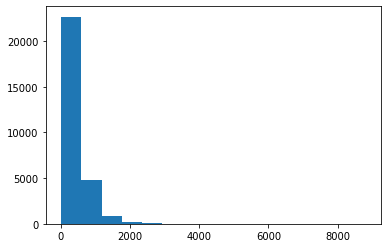

In [47]:
# Check distribution of protein sequences at character level
import matplotlib.pyplot as plt 
plt.hist(char_lens, bins=15)

In [48]:
# What character length covers 95% of the sequenes?
output_seq_char_len = int(np.percentile(char_lens, 99))
output_seq_char_len

2114

In [49]:
max_vocab_length =  22 # add one for OOV token
max_sequence_length = output_seq_char_len # length that covers 97% of our protein sequences

char_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_sequence_length,
                                    #pad_to_max_tokens=False,
                                    #split='character', #could optionally specify this parameter if we didn't split characters previously
                                    name='char_vectorizer')

In [50]:
np.asarray(all_seq_char[0])

array('M A L K S L V L L S L L V L V L L L V R V Q P S L G K E T A A A K F E R Q H M D S S T S A A S S S N Y C N Q M M K S R N L T K D R C K P V N T F V H E S L A D V Q A L C S Q K N V A C K N G Q T N C Y Q S Y S T M S I T D C R E T G S S K Y P N C A Y K T T Q A N K H I I V A C E G N P Y V P V H F D A S V',
      dtype='<U299')

In [51]:
char_vectorizer.adapt(np.asarray(all_seq_char))

In [52]:
char_vectorizer.get_config()

{'name': 'char_vectorizer',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 22,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 2114,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [54]:
list_ = [split_chars(sequence) for sequence in test_df['protein_sequence']]
list_[0]

'V P V N P E P D A T S V E N V A E K T G S G D S Q S D P I K A D L E V K G Q S A L P F D V D C W A I L C K G A P N V L Q R V N E K T K N S N R D R S G A N K G P F K D P Q K W G I K A L P P K N P S W S A Q D F K S P E E Y A F A S S L Q G G T N A I L A P V N L A S Q N S Q G G V L N G F Y S A N K V A Q F D P S K P Q Q T K G T W F Q I T K F T G A A G P Y C K A L G S N D K S V C D K N K N I A G D W G F D P A K W A Y Q Y D E K N N K F N Y V G K'

In [56]:
list_ = list(test_df['protein_sequence'].values)
list_[0]

'VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

In [57]:
letter_dict = {}
for idx, letter in enumerate(list_[2]):
  letter_dict[letter] = list_[2].count(letter)

letter_dict

{'V': 13,
 'P': 17,
 'N': 19,
 'E': 7,
 'D': 15,
 'A': 22,
 'T': 8,
 'S': 18,
 'K': 24,
 'G': 19,
 'Q': 13,
 'I': 6,
 'L': 10,
 'F': 10,
 'C': 4,
 'W': 6,
 'R': 3,
 'Y': 6}

In [53]:
# Testing char_vectorizer on one sequence (padded with zeros)
import random
idx = random.randint(0, len(features_df))
vectorized_char_sequence = char_vectorizer(split_chars(features_df['protein_sequence'].iloc[idx]))
vectorized_char_sequence.numpy()

array([18,  8, 13, ...,  0,  0,  0])

In [54]:
vectorized_char_sequence[:500]

<tf.Tensor: shape=(500,), dtype=int64, numpy=
array([18,  8, 13, 16,  4,  7, 13, 13, 21,  4,  4,  6,  3,  9, 11, 11,  4,
       16,  4, 13,  7, 15, 13,  5,  6, 15,  6,  7,  3,  3,  8,  8,  8, 13,
        8,  8,  8,  8, 13,  8,  8,  8,  8,  3,  3,  7, 13, 15,  4, 15,  2,
       15,  7, 15,  8,  3,  3,  4,  8, 16, 12, 17, 10, 14,  6, 10,  6, 13,
        2,  3, 13, 13, 14,  9,  5,  5,  9,  9,  9, 17,  4,  9,  7,  4,  9,
        6, 11, 10,  3, 18, 19,  8,  7,  8,  5,  6, 10, 11,  4,  8, 14, 10,
       13, 13, 12, 14,  3, 12,  8,  6,  6,  8,  8,  4,  2,  8,  2,  8, 13,
        4,  2,  3, 14,  3,  3,  2,  4,  3, 18,  4,  3, 12,  5,  5, 12, 12,
       13,  3,  3, 15,  5,  2,  3,  5,  8,  2, 14,  5,  4,  2,  2,  6,  6,
       10, 16, 10, 17, 11, 15,  4, 14,  2, 17,  5, 12, 12,  5, 10,  8,  3,
        4,  3,  2, 16, 10,  8,  9,  5,  5,  3, 16,  4,  3, 17, 19,  3,  6,
       17, 10, 14, 14,  7,  4,  8, 21, 13, 11, 15, 13,  2, 15, 10, 11, 11,
        8, 12, 11,  8,  8, 11, 13,  8, 12,  3, 11, 11,

In [55]:
# Check padded length
len(vectorized_char_sequence.numpy())

2114

In [56]:
tf.squeeze(char_vectorizer([all_seq_char[idx]])).numpy().max() # max integer value is 21

21

In [57]:
 # Character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"Unique letters in the protein sequences:\n {set(list(char_vocab))}")

Number of different characters in character vocab: 22
Unique letters in the protein sequences:
 {'', 'k', 'e', 'g', 'm', 'v', 'n', 'a', 'c', 'p', 'f', 'r', 'i', 'y', 'l', 'd', 'w', '[UNK]', 'h', 's', 't', 'q'}


In [58]:
# Test out character vectorizer
import random
random_train_seq = random.choice(all_seq_char)
print(f"Charified text:\n {random_train_seq}")
print(f"\nLength of random_train_chars: {len(random_train_seq.split(sep=' '))}")
print(f"\nVectorized chars:\n {char_vectorizer(random_train_seq)}")
print(f"\nLength of vectorized chars: {len(char_vectorizer(random_train_seq))}")

Charified text:
 M S D W K V D P D T R R R L L Q L Q K I G A N K K C M D C G A P N P Q W A T P K F G A F I C L E C A G I H R G L G V H I S F V R S I T M D Q F K P E E L L R M E K G G N E P L T E W F K S H N I D L S L P Q K V K Y D N P V A E D Y K E K L T C L C E D R V F E E R E H L D F D A S K L S A T S Q T A A S A T P G V A Q S R E G T P L E N R R S A T P A N S S N G A N F Q K E K N E A Y F A E L G K K N Q S R P D H L P P S Q G G K Y Q G F G S T P A K P P Q E R S A G S S N T L S L E N F Q A D P L G T L S R G W G L F S S A V T K S F E D V N E T V I K P H V Q Q W Q S G E L S E E T K R A A A Q F G Q K F Q E T S S Y G F Q A F S N F T K N F N G N A E D S S T A G N T T H T E Y Q K I D N N D K K N E Q D E D K W D D

Length of random_train_chars: 351

Vectorized chars:
 [18  5  9 ...  0  0  0]

Length of vectorized chars: 2114


In [59]:
max_sequence_length, max_vocab_length

(2114, 22)

In [61]:
# Creating a character-level embedding layer 
from tensorflow.keras import layers
character_embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set the input shape, number of different characters, max int value is 21
                                       output_dim=256, 
                                       mask_zero=True,
                                       input_length=max_sequence_length)

In [62]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_seq}\n")
print(f"Length of charified text: {round(len(random_train_seq)/2)}\n")
char_embed_example = character_embedding(char_vectorizer([random_train_seq]))
print(f"Embedded chars: (after vectorization and embedding)\n {char_embed_example}\n")
print(f"Shape of character embeddings:\n {char_embed_example.shape}") # [batch_size, input_length, embedding dim]

Charified text:
 M S D W K V D P D T R R R L L Q L Q K I G A N K K C M D C G A P N P Q W A T P K F G A F I C L E C A G I H R G L G V H I S F V R S I T M D Q F K P E E L L R M E K G G N E P L T E W F K S H N I D L S L P Q K V K Y D N P V A E D Y K E K L T C L C E D R V F E E R E H L D F D A S K L S A T S Q T A A S A T P G V A Q S R E G T P L E N R R S A T P A N S S N G A N F Q K E K N E A Y F A E L G K K N Q S R P D H L P P S Q G G K Y Q G F G S T P A K P P Q E R S A G S S N T L S L E N F Q A D P L G T L S R G W G L F S S A V T K S F E D V N E T V I K P H V Q Q W Q S G E L S E E T K R A A A Q F G Q K F Q E T S S Y G F Q A F S N F T K N F N G N A E D S S T A G N T T H T E Y Q K I D N N D K K N E Q D E D K W D D

Length of charified text: 350

Embedded chars: (after vectorization and embedding)
 [[[ 0.00665807  0.00865964 -0.02650158 ...  0.02106972  0.00498285
    0.01328632]
  [ 0.00458683  0.04179097  0.04280723 ... -0.0332347   0.02813674
    0.02995602]
  [ 0.0395151   0.02179811  0.

**Idea:** Using `TextVectorization` layer to create and array of counts of each letter in the protein sequences and using that as a source of input for the model

In [63]:
max_vocab_length = 20
letter_count_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='count',
                                    #output_sequence_length=max_sequence_length,
                                    pad_to_max_tokens=False,
                                    #split='character', #could optionally specify this parameter if we didn't split characters previously
                                    name='char_vectorizer')

In [64]:
letter_count_vectorizer.adapt(np.asarray(all_seq_char))

In [65]:
# Testing char_vectorizer on one sequence (padded with zeros)
import random
idx = random.randint(0, len(features_df))
vectorized_char_sequence = letter_count_vectorizer(all_seq_char[idx])
vectorized_char_sequence.numpy()

array([ 2., 34., 48., 34., 30., 37., 42., 24., 32., 32., 38., 19., 18.,
       20., 21., 20., 18., 12., 16.,  7.], dtype=float32)

In [66]:
# Will produce constant size tensor equal to [max tokens] parameter
vectorized_char_sequence.shape

TensorShape([20])

In [67]:
list_ = all_seq_char[idx]
list_

'M C G I V G I V A K S H V N Q S I Y D A L T I L Q H R G Q D A A G I V T W H N D K L F L R K D N G L V S D V F R T R H M K R L V G H I G I G H V R Y P T A G S S S S A E A Q P F Y V N S P Y G I T L A H N G N L T N A A E V A E H L Y K E D L R H I N T T S D S E V L L N V F A H E M Q K Q G E L I P T P E S I F K A I A R V H Q R I R G G Y S V V A M I N G F G L V A F R D P N G I R P A V F G V R E R E H G K E Y M V A S E S V A L D G L G F K L V R D I A P G E C I V I T K E G E F F S Q Q C A E D P K L V P C I F E H V Y F A R P D S I M D G I S V Y K A R L K M G E Y L A G K I M K E R P D H D I D V V I P I P D T S R T S A L Q L A N R L G V K Y R E G F M K N R Y I G R T F I M P G Q Q Q R K K S V K Q K L N A I A L E F A G K N V L L V D D S I V R G T T C N Q I I E M A R E A G A K N V Y F A S A A P E V R Y P N V Y G I D M P A V E E L I A H D R T V A E I E T A I G A D W L I Y Q D L E D L Q R S C L N G A S T E V Q E F D C S V F D A Q Y V T G D I D E A Y F E R L R V A R S D A S K S S A N S A E D V A I D L

In [68]:
letter_dict = {}
for letter in list_:
  letter_dict[letter] = list_.count(letter)

letter_dict

{'M': 12,
 ' ': 503,
 'C': 7,
 'G': 37,
 'I': 38,
 'V': 42,
 'A': 48,
 'K': 24,
 'S': 30,
 'H': 16,
 'N': 21,
 'Q': 20,
 'Y': 18,
 'D': 32,
 'L': 34,
 'T': 19,
 'R': 32,
 'W': 2,
 'F': 20,
 'P': 18,
 'E': 34}

## Modelling Experiments to run
- Conv1D 
- LSTM
- Bidirectional LSTM
- GRU


## Creating performant datasets (training and validation sets)

In [ ]:
# Turn our 10% data into TensorFlow Datasets  from the dataframes
# train_features_10_percent = tf.data.Dataset.from_tensor_slices((tf.cast(train_features_10_percent_df['protein_sequence'].values, tf.string),
# tf.cast(train_features_10_percent_df['pH'].values, tf.float32)))
# train_labels_10_percent = tf.data.Dataset.from_tensor_slices(tf.cast(train_targets_10_percent, tf.float32))
# train_dataset_10_percent = tf.data.Dataset.zip((train_features_10_percent, train_labels_10_percent))

# # Take 10% of the data and turn it into TensorFlow Datasets
# val_features = tf.data.Dataset.from_tensor_slices((tf.cast(val_features_df['protein_sequence'].values, tf.string), 
#                                                    val_pH))
# val_labels = tf.data.Dataset.from_tensor_slices(tf.cast(val_targets, tf.float32))
# val_dataset = tf.data.Dataset.zip((val_features, val_labels))

# # Turn test_df into TensorFlow Datasets
# test_data = tf.data.Dataset.from_tensor_slices((tf.cast(test_df['protein_sequence'].values, tf.string),
#                                                    tf.cast(test_df['pH'], tf.float32)))

# train_dataset_10_percent, val_dataset, test_data

(<ZipDataset element_spec=((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.float32, name=None))>,
 <ZipDataset element_spec=((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.float32, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>)

In [69]:
test_df[['pH']].max(), test_df[['pH']].min()

(pH    8
 dtype: int64, pH    8
 dtype: int64)

In [70]:
test_char_seq = tf.cast([split_chars(sequence) for sequence in test_df['protein_sequence']], tf.string)
test_ph_norm = tf.cast(test_df['pH'].values/11, tf.float32)
test_ph = tf.cast(test_df['pH'].values, tf.float32)
test_char_seq[:2], test_ph_norm[:2]

(<tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b'V P V N P E P D A T S V E N V A E K T G S G D S Q S D P I K A D L E V K G Q S A L P F D V D C W A I L C K G A P N V L Q R V N E K T K N S N R D R S G A N K G P F K D P Q K W G I K A L P P K N P S W S A Q D F K S P E E Y A F A S S L Q G G T N A I L A P V N L A S Q N S Q G G V L N G F Y S A N K V A Q F D P S K P Q Q T K G T W F Q I T K F T G A A G P Y C K A L G S N D K S V C D K N K N I A G D W G F D P A K W A Y Q Y D E K N N K F N Y V G K',
        b'V P V N P E P D A T S V E N V A K K T G S G D S Q S D P I K A D L E V K G Q S A L P F D V D C W A I L C K G A P N V L Q R V N E K T K N S N R D R S G A N K G P F K D P Q K W G I K A L P P K N P S W S A Q D F K S P E E Y A F A S S L Q G G T N A I L A P V N L A S Q N S Q G G V L N G F Y S A N K V A Q F D P S K P Q Q T K G T W F Q I T K F T G A A G P Y C K A L G S N D K S V C D K N K N I A G D W G F D P A K W A Y Q Y D E K N N K F N Y V G K'],
       dtype=object)>,
 <tf.Tensor: shape=(2,

In [105]:
test_letter_counts = letter_count_vectorizer(test_char_seq)
test_letter_counts = test_letter_counts/max_letter_count
test_letter_counts

<tf.Tensor: shape=(2413, 20), dtype=float32, numpy=
array([[0.00520382, 0.00867303, 0.01908066, ..., 0.        , 0.        ,
        0.00346921],
       [0.00520382, 0.00867303, 0.01908066, ..., 0.        , 0.        ,
        0.00346921],
       [0.00520382, 0.00867303, 0.01908066, ..., 0.        , 0.        ,
        0.00346921],
       ...,
       [0.00520382, 0.00954033, 0.01821336, ..., 0.        , 0.        ,
        0.00346921],
       [0.00520382, 0.00954033, 0.01821336, ..., 0.        , 0.        ,
        0.00346921],
       [0.00607112, 0.00954033, 0.01821336, ..., 0.        , 0.        ,
        0.00346921]], dtype=float32)>

In [97]:
test_tribrid_char_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(test_letter_counts, tf.float32),test_char_seq, test_ph_norm))
test_tribrid_char_dataset = test_tribrid_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_tribrid_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
# Turn test_df into TensorFlow Datasets
test_char_sequences = tf.data.Dataset.from_tensor_slices(test_char_seq)
test_ph = tf.data.Dataset.from_tensor_slices(test_ph_norm)
test_char_dataset = tf.data.Dataset.zip((test_char_sequences, test_ph))
test_char_dataset                                             


<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
list(test_char_dataset.as_numpy_iterator())[0]

(b'V P V N P E P D A T S V E N V A E K T G S G D S Q S D P I K A D L E V K G Q S A L P F D V D C W A I L C K G A P N V L Q R V N E K T K N S N R D R S G A N K G P F K D P Q K W G I K A L P P K N P S W S A Q D F K S P E E Y A F A S S L Q G G T N A I L A P V N L A S Q N S Q G G V L N G F Y S A N K V A Q F D P S K P Q Q T K G T W F Q I T K F T G A A G P Y C K A L G S N D K S V C D K N K N I A G D W G F D P A K W A Y Q Y D E K N N K F N Y V G K',
 0.72727275)

In [ ]:
test_dataset = test_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [83]:
features_df.head()

,protein_sequence,pH
5152,MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...,5.0
14069,MKIAGIDEAGRGPVIGPMVIAAVVVDENSLPKLEELKVRDSKKLTP...,9.0
15645,MLKGGMLSRWKMWSPQYKILRNHLINFKSVSTYKNISGVNTKQPKS...,7.0
23899,MSGLGESSLDPLAAESRKRKLPCDAPGQGLVYSGEKWRREQESKYI...,7.0
11295,MGGASCVTFSLDGKFLAIGLQKGAIKIMTIDNKLYHMIDEGGQPGQ...,7.0


In [84]:
targets_df.head()

,tm
5152,40.0
14069,50.0
15645,47.4
23899,47.2
11295,37.3


In [71]:
from sklearn.model_selection import train_test_split  

X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(features_df, targets_df, test_size=0.05,
                                                              random_state=7)
len(X_train_df), len(X_val_df), len(y_train_df), len(y_val_df)

(27260, 1435, 27260, 1435)

In [72]:
X_train_df[['protein_sequence']] = X_train_df[['protein_sequence']].applymap(lambda x: split_chars(x))
X_train_df

,protein_sequence,pH
3883,M A D S K P L R T L D G D P V A V E A L L Q D ...,7.0
14781,M K P L S S P L Q Q Y W Q T V V E R L P E P L ...,7.0
1788,G L L Y T S V H Q V I E L P A P A Q P I S V T ...,7.0
25827,M S S S E E V S W V T W F C G L R G N E F F C ...,7.0
9601,M E P K T K K Q R S L Y I P Y A G P V L L E F ...,7.0
...,...,...
14238,M K I N Q F G T Q S V N P Y Q K N Y D K Q A V ...,7.0
22040,M R L P R S L A A A L Y Q T Q N T Q S K R S I ...,7.0
11382,M G I I I F I K K N I P I A W R I A T S I V L ...,7.0
2165,K C A D R P Y V L E T E E G L L G G E N L S Y ...,7.0


In [73]:
y_train_df.head()

,tm
3883,61.1
14781,48.5
1788,52.5
25827,43.7
9601,46.8


In [74]:
X_val_df[['protein_sequence']] = X_val_df[['protein_sequence']].applymap(lambda x: split_chars(x))
X_val_df

,protein_sequence,pH
27980,M T T A V L N D P T S S W G E S A K H V N A S ...,7.0
6500,M A S T A D G D M G E T L E Q M R G L W P G V ...,7.0
28246,M T Y N Q M P K A Q G L Y R P E F E H D A C G ...,7.0
14974,M K S F S N K V A V I T G A G S G I G R A L A ...,7.0
8397,M D W E E R E N P R R L V K T F A F P N F R E ...,7.0
...,...,...
16485,M L T K S A E N K R N R K D D S M R P G Q Q L ...,7.0
24903,M S N D G D L N I D N L I T R L L E V R G C R ...,7.0
18198,M N F V T T P E S R F K H L P N Y Q F K A N Y ...,7.0
6937,M A T V T T H A S A S I F R P C T S K P R F L ...,7.0


In [75]:
y_val_df.head()

,tm
27980,35.0
6500,45.4
28246,38.8
14974,49.3
8397,93.8


In [76]:
tf.squeeze(y_train_df.values)

<tf.Tensor: shape=(27260,), dtype=float64, numpy=array([61.1, 48.5, 52.5, ..., 43.6, 89.7, 41.9])>

In [77]:
np.unique(features_df['pH'])

array([ 1.99,  2.  ,  2.02,  2.03,  2.1 ,  2.2 ,  2.3 ,  2.34,  2.4 ,
        2.5 ,  2.53,  2.7 ,  2.8 ,  2.81,  2.83,  2.84,  2.86,  2.9 ,
        2.94,  2.98,  3.  ,  3.01,  3.02,  3.04,  3.07,  3.1 ,  3.14,
        3.15,  3.16,  3.19,  3.2 ,  3.21,  3.25,  3.3 ,  3.5 ,  3.6 ,
        3.7 ,  3.75,  3.8 ,  3.9 ,  4.  ,  4.1 ,  4.2 ,  4.25,  4.3 ,
        4.4 ,  4.5 ,  4.6 ,  4.7 ,  4.75,  4.8 ,  4.9 ,  5.  ,  5.1 ,
        5.2 ,  5.28,  5.3 ,  5.31,  5.35,  5.38,  5.4 ,  5.42,  5.45,
        5.5 ,  5.6 ,  5.7 ,  5.8 ,  5.9 ,  6.  ,  6.1 ,  6.2 ,  6.3 ,
        6.4 ,  6.5 ,  6.6 ,  6.7 ,  6.78,  6.8 ,  6.9 ,  7.  ,  7.1 ,
        7.2 ,  7.3 ,  7.4 ,  7.5 ,  7.6 ,  7.7 ,  7.8 ,  8.  ,  8.2 ,
        8.25,  8.5 ,  8.6 ,  9.  ,  9.08,  9.5 ,  9.6 ,  9.7 ,  9.75,
        9.9 , 10.  , 10.3 , 10.4 , 11.  ])

In [78]:
np.unique(test_df['pH'])

array([8])

In [79]:
features_df['pH'].to_numpy().reshape((-1,1))

array([[5. ],
       [9. ],
       [7. ],
       ...,
       [7. ],
       [2.2],
       [7. ]])

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()
#print(scaler.fit_transform(features_df['pH'].to_numpy().reshape((-1,1))))

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(features_df['pH'].to_numpy().reshape((-1,1)))

MinMaxScaler()

In [82]:
train_seq_char = tf.cast(X_train_df['protein_sequence'].values, tf.string)
train_ph = tf.cast(min_max_scaler.transform(X_train_df['pH'].values.reshape((-1,1))), tf.float32)
train_targets = tf.cast(tf.squeeze(y_train_df.values), tf.float32)
val_seq_char = tf.cast(X_val_df['protein_sequence'].values, tf.string)
val_ph = tf.cast(min_max_scaler.transform(X_val_df['pH'].values.reshape((-1,1))), tf.float32)
val_targets = tf.cast(tf.squeeze(y_val_df.values), tf.float32)

len(train_seq_char), len(train_ph), len(train_targets), len(val_seq_char), len(val_ph), len(val_targets)

(27260, 27260, 27260, 1435, 1435, 1435)

In [118]:
test_char_seq = tf.cast([split_chars(sequence) for sequence in test_df['protein_sequence']], tf.string)
test_ph_norm = min_max_scaler.transform(tf.cast(test_df['pH'].values.reshape((-1,1)), tf.float32))
test_ph = tf.cast(test_df['pH'].values, tf.float32)
test_char_seq[:2], test_ph_norm[:2]

(<tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b'V P V N P E P D A T S V E N V A E K T G S G D S Q S D P I K A D L E V K G Q S A L P F D V D C W A I L C K G A P N V L Q R V N E K T K N S N R D R S G A N K G P F K D P Q K W G I K A L P P K N P S W S A Q D F K S P E E Y A F A S S L Q G G T N A I L A P V N L A S Q N S Q G G V L N G F Y S A N K V A Q F D P S K P Q Q T K G T W F Q I T K F T G A A G P Y C K A L G S N D K S V C D K N K N I A G D W G F D P A K W A Y Q Y D E K N N K F N Y V G K',
        b'V P V N P E P D A T S V E N V A K K T G S G D S Q S D P I K A D L E V K G Q S A L P F D V D C W A I L C K G A P N V L Q R V N E K T K N S N R D R S G A N K G P F K D P Q K W G I K A L P P K N P S W S A Q D F K S P E E Y A F A S S L Q G G T N A I L A P V N L A S Q N S Q G G V L N G F Y S A N K V A Q F D P S K P Q Q T K G T W F Q I T K F T G A A G P Y C K A L G S N D K S V C D K N K N I A G D W G F D P A K W A Y Q Y D E K N N K F N Y V G K'],
       dtype=object)>, array([[0.66703663],
 

### Create charified `tf.data.Dataset`

In [59]:
# Create charified tf.data.Dataset with two inputs, seqeunce and ph value
### Train dataset ###
# char_train_features = tf.data.Dataset.from_tensor_slices((train_seq_char, train_ph))
# train_labels = tf.data.Dataset.from_tensor_slices(train_targets)
# train_char_dataset = tf.data.Dataset.zip((char_train_features, train_labels))
# train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# ### Validation dataset ###
# char_val_features = tf.data.Dataset.from_tensor_slices((val_seq_char, val_ph))
# char_val_labels = tf.data.Dataset.from_tensor_slices(val_targets)
# val_char_dataset = tf.data.Dataset.zip((char_val_features, char_val_labels))
# val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# train_char_dataset, val_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

### Create Tribrid dataset

In [88]:
train_seq_char.numpy()[0].decode()

'M A D S K P L R T L D G D P V A V E A L L Q D V F G I V V D E A I L K G T S A S E K V C E W K E P E E L K Q L L D L E L Q S Q G E S R E Q I L E R C R T V I H Y S V K T G H P R F F N Q L F S G L D P H A L A G R I I T E S L N T S Q Y T Y E I A P V F V L M E E E V L K K L R A L V G W N S G D G V F C P G G S I S N M Y A M N L A R F Q R Y P D C K Q R G L R A L P P L A L F T S K E C H Y S I T K G A A F L G L G T D S V R V V K A D E R G R M I P E D L E R Q I I L A E A E G S V P F L V S A T S G T T V L G A F D P L D A I A D V C Q R H G L W F H V D A A W G G S V L L S R T H R H L L D G I Q R A D S V A W N P H K L L A A G L Q C S A L L L R D T S N L L K R C H G S Q A S Y L F Q Q D K F Y D V A L D T G D K V V Q C G R R V D C L K L W L M W K A Q G G Q G L E R R I D Q A F A L T R Y L V E E I K K R E G F E L V M E P E F V N V C F W F V P P S L R G K K E S P D Y S Q R L S Q V A P V L K E R M V K K G T M M I G Y Q P H G T R A N F F R M V V A N P I L A Q A D I D F L L G E L E L L G Q D'

In [89]:
letter_count_vectorizer(train_seq_char.numpy()[2]) == letter_count_vectorizer(train_seq_char.numpy()[2].decode())

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

In [90]:
train_letter_counts = letter_count_vectorizer(train_seq_char)
train_letter_counts

<tf.Tensor: shape=(27260, 20), dtype=float32, numpy=
array([[  8.,  62.,  39., ...,  11.,  11.,  11.],
       [ 21., 127.,  88., ...,  27.,  21.,   9.],
       [  1.,   9.,  19., ...,   3.,   1.,   0.],
       ...,
       [  3.,  54.,  31., ...,  12.,  17.,   4.],
       [  6.,  88.,  65., ...,   3.,   3.,   7.],
       [  2.,  45.,  21., ...,   9.,   8.,   4.]], dtype=float32)>

In [91]:
val_letter_counts = letter_count_vectorizer(val_seq_char)
val_letter_counts

<tf.Tensor: shape=(1435, 20), dtype=float32, numpy=
array([[  1.,  21.,  13., ...,   6.,  14.,   5.],
       [ 12.,  74.,  26., ...,  16.,  13.,  10.],
       [ 14., 126., 122., ...,  36.,  35.,  10.],
       ...,
       [  7.,  25.,  25., ...,  11.,  10.,   4.],
       [  6.,  25.,  18., ...,   4.,   5.,   1.],
       [  4.,  42.,  41., ...,  11.,   9.,   5.]], dtype=float32)>

In [92]:
min_max_scaler_count = MinMaxScaler()
min_max_scaler_count.fit(train_letter_counts)

MinMaxScaler()

In [93]:
val_letter_counts.numpy()[0]

array([ 1., 21., 13., 13., 20., 14., 21., 10., 16., 25., 17., 16., 10.,
       11., 15., 10., 13.,  6., 14.,  5.], dtype=float32)

In [94]:
max_letter_count = 0
for array in train_letter_counts.numpy():
  if array.max() > max_letter_count:
    max_letter_count = array.max()

print(max_letter_count)
    

1153.0


In [95]:
max_ = 0
for array in val_letter_counts.numpy():
  if array.max() > max_:
    max_ = array.max()

print(max_)
    

618.0


In [97]:
train_letter_counts = min_max_scaler_count.transform(train_letter_counts)
val_letter_counts = min_max_scaler_count.transform(val_letter_counts)
train_letter_counts, val_letter_counts

(array([[0.0610687 , 0.05377277, 0.04290429, ..., 0.05164319, 0.03571429,
         0.03030303],
        [0.16030534, 0.11014744, 0.09680968, ..., 0.12676056, 0.06818182,
         0.02479339],
        [0.00763359, 0.00780572, 0.02090209, ..., 0.01408451, 0.00324675,
         0.        ],
        ...,
        [0.02290076, 0.04683435, 0.03410341, ..., 0.05633803, 0.05519481,
         0.01101928],
        [0.04580153, 0.07632264, 0.07150715, ..., 0.01408451, 0.00974026,
         0.01928375],
        [0.01526718, 0.03902862, 0.02310231, ..., 0.04225352, 0.02597403,
         0.01101928]]),
 array([[0.00763359, 0.01821336, 0.01430143, ..., 0.02816901, 0.04545455,
         0.0137741 ],
        [0.09160305, 0.0641804 , 0.02860286, ..., 0.07511737, 0.04220779,
         0.02754821],
        [0.10687023, 0.10928014, 0.13421342, ..., 0.16901408, 0.11363636,
         0.02754821],
        ...,
        [0.05343511, 0.02168257, 0.02750275, ..., 0.05164319, 0.03246753,
         0.01101928],
        [0.0

In [98]:
train_letter_counts.shape, val_letter_counts.shape

((27260, 20), (1435, 20))

In [99]:
# Create charified tf.data.Dataset
### Train dataset ###
char_train_features = tf.data.Dataset.from_tensor_slices((tf.cast(train_letter_counts, tf.float32), train_seq_char, train_ph))
train_labels = tf.data.Dataset.from_tensor_slices(train_targets)
train_char_dataset = tf.data.Dataset.zip((char_train_features, train_labels))
tribrid_train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


### Validation dataset ###
char_val_features = tf.data.Dataset.from_tensor_slices((tf.cast(val_letter_counts, tf.float32), val_seq_char, val_ph))
char_val_labels = tf.data.Dataset.from_tensor_slices(val_targets)
val_char_dataset = tf.data.Dataset.zip((char_val_features, char_val_labels))
tribrid_val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


tribrid_train_char_dataset, tribrid_val_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [106]:
### Train dataset ###
char_train_features = tf.data.Dataset.from_tensor_slices((train_seq_char, train_ph))
train_labels = tf.data.Dataset.from_tensor_slices(train_targets)
train_char_dataset = tf.data.Dataset.zip((char_train_features, train_labels))
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


### Validation dataset ###
char_val_features = tf.data.Dataset.from_tensor_slices((val_seq_char, val_ph))
char_val_labels = tf.data.Dataset.from_tensor_slices(val_targets)
val_char_dataset = tf.data.Dataset.zip((char_val_features, char_val_labels))
val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_char_dataset, val_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [100]:
# Create function to plot historys
import matplotlib.pyplot as plt

def plot_historys(history):
  """
  A function to plot the loss and accuracy of a Tensorflow model

  Args
  -----
  history : history object from a trained TensorFlow Model 
  """
  # Get variables from history object
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  mae = history.history['mae']
  val_mae = history.history['val_mae']
  epochs = history.epoch

  # Plot the loss and mse 
  fig = plt.figure(figsize=(10,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.legend()
  plt.xlabel("Epochs")
  plt.title("Training Loss vs. Val Loss")

  plt.subplot(1,2,2)
  plt.plot(epochs, mae, label='training_mae')
  plt.plot(epochs, val_mae, label='val_mae')
  plt.legend()
  plt.xlabel("Epochs")
  plt.title("Training MAE vs. Val MAE")

In [101]:
# Setup some callbacks
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4,
                              patience=6, min_delta=1, min_lr=0.00001, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=12, min_delta=0.5,
                               restore_best_weights=True)

In [102]:
import os 
os.mkdir("model_experiments/")

In [103]:
checkpoint_dir = "/content/model_experiments"

In [104]:
# Create ModelCheckpoint callback to save our model's progress during training 
def model_checkpoint(model_name:str):
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir + "/" + model_name,
                                                        monitor='val_loss',
                                                        save_best_only=True,
                                                        save_weights_only=True,
                                                        verbose=0)
  return model_checkpoint

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
BATCH_SIZE = 32

In [ ]:
SAVE_DIR = "novoenzyme_model_logs"

In [ ]:
# 1. Setup protein sequence inputs
# Inputs are 1D strings of characters
sequence_inputs = layers.Input(shape=(1,), batch_size=BATCH_SIZE, dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Conv1D(64, kernel_size = 3, activation='relu')(sequence_embeddings)
x = layers.Conv1D(32, kernel_size=3, activation='relu')(x)
sequence_outputs = layers.GlobalMaxPooling1D()(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), batch_size = BATCH_SIZE, dtype=tf.float32, name='ph_inputs'
pH_outputs = layers.Dense(128, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# Concatenate sequence and pH inputs 
sequence_pH_concat = layers.Concatenate(name='concatenation')([sequence_model.output, 
                                                               pH_model.output])

combined_dense = layers.Dense(128, activation='relu')(sequence_pH_concat)
output_layer = layers.Dense(1, activation='linear')(combined_dense) 

# Construct the model 
model_1 = tf.keras.Model(inputs=[sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_1_Conv1D')

### Model 1: Conv1D

In [ ]:
model_1.summary()

Model: "model_1_Conv1D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_inputs (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 536)         0           ['sequence_inputs[0][0]']        
 tion)                                                                                            
                                                                                                  
 embedding (Embedding)          (None, 536, 128)     2816        ['char_vectorizer[0][0]']        
                                                                                                  
 conv1d (Conv1D)                (None, 534, 64)      24640       ['embedding[0][0]'] 

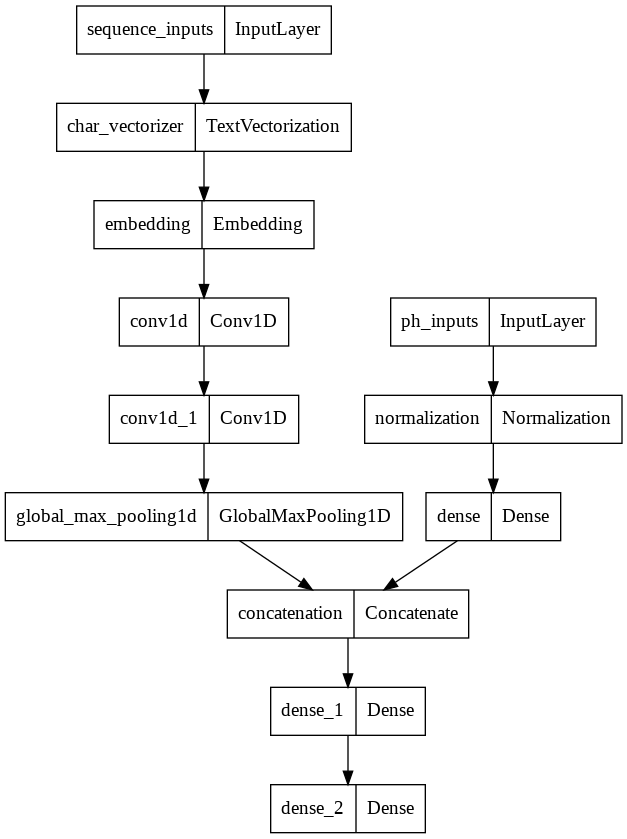

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_1)

In [ ]:
model_1.compile(loss ='mse', # will use mse for loss as bigger errors should be penlized more given the problem statement 
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae', 'mse']) # want mae too as intuitive with how far off our predicted target numbers are

In [ ]:
history_1 = model_1.fit(train_dataset_10_percent, 
                        steps_per_epoch = len(train_dataset_10_percent),
                        epochs=30,
                        validation_data=val_dataset,
                        validation_steps = int(0.25*len(val_dataset)),
                        callbacks=[reduce_lr, early_stopping, model_checkpoint(model_1.name),
                                   create_tensorboard_callback(SAVE_DIR, model_1.name)])

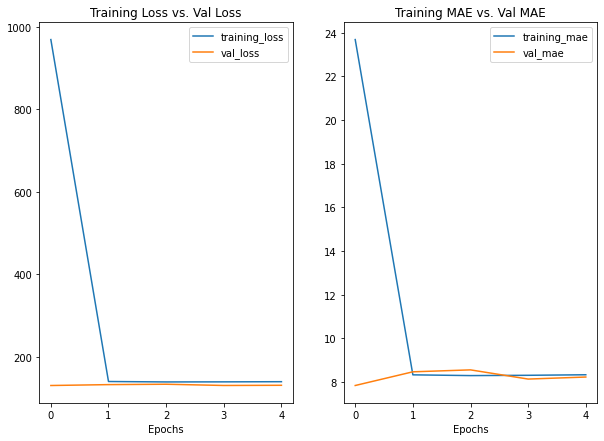

In [ ]:
plot_historys(history_1)

In [ ]:
model_1.evaluate(val_dataset)

90/90 [==============================] - 0s 5ms/step - loss: 140.6326 - mae: 8.1402 - mse: 140.6326


[140.63262939453125, 8.140247344970703, 140.63262939453125]

In [ ]:
model_1.get_weights()

In [ ]:
test_df_shuffled = test_df.sample(frac=1)

In [ ]:
model_1_preds = model_1.predict((test_df_shuffled['protein_sequence'].apply(split_chars).values, normalizer1(test_df_shuffled['pH'].values)))

76/76 [==============================] - 0s 4ms/step


In [ ]:
model_1_preds[200:300], model_1_preds.shape

In [ ]:
model_1.save("/content/drive/MyDrive/Novozyme_Competition/novozyme_competition/model_1")

## Model_2 LSTM 

In [ ]:
# 1. Setup protein sequence inputs
sequence_inputs = layers.Input(shape=(1), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.LSTM(64, return_sequences=True)(sequence_embeddings)
sequence_outputs = layers.LSTM(64)(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
norm1 = normalizer1(pH_inputs)
pH_outputs = layers.Dense(128, activation='relu')(norm1)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# Concatenate sequence and pH inputs 
sequence_pH_concat = layers.Concatenate(name='concatenation')([sequence_model.output, 
                                                               pH_model.output])

combined_dense = layers.Dense(128, activation='relu')(sequence_pH_concat)
final_dense = layers.Dense(128, activation='relu')(combined_dense)
output_layer = layers.Dense(1, activation='linear')(final_dense)

# Construct the model 
model_2 = tf.keras.Model(inputs=[sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_2_LSTM')

In [ ]:
model_2.summary()

In [ ]:
model_2.compile(loss ='mse',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [ ]:
history_2 = model_2.fit(train_dataset_10_percent, 
                        steps_per_epoch = len(train_dataset_10_percent),
                        epochs=30,
                        validation_data=val_dataset,
                        validation_steps = int(0.25*len(val_dataset)),
                        callbacks=[reduce_lr, early_stopping, model_checkpoint(model_2.name)])

Epoch 1/30
88/90 [============================>.] - ETA: 0s - loss: 1099.9474 - mae: 25.6712 - mse: 1099.9474

90/90 [==============================] - 33s 293ms/step - loss: 1082.8689 - mae: 25.3501 - mse: 1082.8689 - val_loss: 136.7740 - val_mae: 7.8776 - val_mse: 136.7740 - lr: 0.0010
Epoch 2/30
86/90 [===========================>..] - ETA: 0s - loss: 142.3603 - mae: 8.3463 - mse: 142.3603

90/90 [==============================] - 20s 224ms/step - loss: 142.2549 - mae: 8.3443 - mse: 142.2549 - val_loss: 133.5756 - val_mae: 8.4151 - val_mse: 133.5756 - lr: 0.0010
Epoch 3/30
87/90 [============================>.] - ETA: 0s - loss: 140.2231 - mae: 8.3275 - mse: 140.2231

90/90 [==============================] - 20s 229ms/step - loss: 139.5647 - mae: 8.3105 - mse: 139.5647 - val_loss: 133.4598 - val_mae: 8.5276 - val_mse: 133.4598 - lr: 0.0010
Epoch 4/30
90/90 [==============================] - ETA: 0s - loss: 138.9572 - mae: 8.3023 - mse: 138.9572
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
90/90 [==============================] - 1s 14ms/step - loss: 138.9572 - mae: 8.3023 - mse: 138.9572 - val_loss: 134.8786 - val_mae: 8.7035 - val_mse: 134.8786 - lr: 0.0010
Epoch 5/30
89/90 [============================>.] - ETA: 0s - loss: 138.5328 - mae: 8.3056 - mse: 138.5328

90/90 [==============================] - 20s 228ms/step - loss: 139.0564 - mae: 8.3170 - mse: 139.0564 - val_loss: 130.7872 - val_mae: 8.2139 - val_mse: 130.7872 - lr: 5.0000e-04
Epoch 6/30
90/90 [==============================] - 1s 14ms/step - loss: 139.3873 - mae: 8.3392 - mse: 139.3873 - val_loss: 131.1226 - val_mae: 8.2754 - val_mse: 131.1226 - lr: 5.0000e-04
Epoch 7/30
88/90 [============================>.] - ETA: 0s - loss: 138.8977 - mae: 8.3298 - mse: 138.8977
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
90/90 [==============================] - 1s 14ms/step - loss: 139.2493 - mae: 8.3347 - mse: 139.2493 - val_loss: 131.4032 - val_mae: 8.3185 - val_mse: 131.4032 - lr: 5.0000e-04
Epoch 8/30
90/90 [==============================] - ETA: 0s - loss: 138.5721 - mae: 8.3137 - mse: 138.5721

90/90 [==============================] - 20s 226ms/step - loss: 138.5721 - mae: 8.3137 - mse: 138.5721 - val_loss: 130.4209 - val_mae: 7.9092 - val_mse: 130.4209 - lr: 2.5000e-04
Epoch 9/30
89/90 [============================>.] - ETA: 0s - loss: 137.9884 - mae: 8.2865 - mse: 137.9884
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


90/90 [==============================] - 20s 226ms/step - loss: 138.5626 - mae: 8.2973 - mse: 138.5626 - val_loss: 130.3718 - val_mae: 7.9129 - val_mse: 130.3718 - lr: 2.5000e-04


In [ ]:
model_2.evaluate(val_dataset)

90/90 [==============================] - 1s 6ms/step - loss: 138.8042 - mae: 8.4371 - mse: 138.8042


[138.8041534423828, 8.437093734741211, 138.8041534423828]

In [ ]:
plot_historys(history_2)

## Bidirectional LSTM

- Two input model 
- Tribrid model

In [68]:
# 1. Setup protein sequence inputs
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_embeddings)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(128, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)


# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])


# 6. Create output layers
combined_dense = layers.Dense(256, activation='relu')(sequence_ph_concat)
combined_dropout = layers.Dropout(0.5)(combined_dense)
x = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.4)(x)
final_dense = layers.Dense(128, activation='relu')(final_dropout)

# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(final_dense) 

# Construct the model 
model_3 = tf.keras.Model(inputs=[sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_3_bidirectional_LSTM')

In [69]:
model_3.summary() 

Model: "model_3_bidirectional_LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_inputs (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 1374)        0           ['sequence_inputs[0][0]']        
 tion)                                                                                            
                                                                                                  
 embedding (Embedding)          (None, 1374, 128)    2688        ['char_vectorizer[0][0]']        
                                                                                                  
 bidirectional (Bidirectional)  (None, 1374, 128)    98816       ['embedd

In [70]:
model_3.compile(loss='mse',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['mae'])

In [75]:
model_3.load_weights("/content/drive/MyDrive/model_3_bidirectional_LSTM")

In [76]:
model_3.evaluate(val_char_dataset)

45/45 [==============================] - 19s 113ms/step - loss: 53.5737 - mae: 5.5704


[53.57374954223633, 5.570354461669922]

In [77]:
history_3 = model_3.fit(train_char_dataset, 
                        epochs=100,
                        steps_per_epoch = len(train_char_dataset),
                        validation_data=val_char_dataset,
                        validation_steps = len(val_char_dataset),
                        callbacks=[reduce_lr, early_stopping, model_checkpoint(model_3.name)])

Epoch 1/100
852/852 [==============================] - 190s 207ms/step - loss: 61.0077 - mae: 5.8783 - val_loss: 51.7049 - val_mae: 5.4915 - lr: 0.0010
Epoch 2/100
852/852 [==============================] - 176s 207ms/step - loss: 59.2844 - mae: 5.7934 - val_loss: 52.4890 - val_mae: 5.4694 - lr: 0.0010
Epoch 3/100
852/852 [==============================] - 177s 207ms/step - loss: 57.5309 - mae: 5.7224 - val_loss: 57.4088 - val_mae: 5.6700 - lr: 0.0010
Epoch 4/100
852/852 [==============================] - 180s 211ms/step - loss: 56.2924 - mae: 5.6723 - val_loss: 54.6354 - val_mae: 5.5572 - lr: 0.0010
Epoch 5/100
852/852 [==============================] - 179s 210ms/step - loss: 54.5275 - mae: 5.5897 - val_loss: 55.8888 - val_mae: 5.5423 - lr: 0.0010
Epoch 6/100
852/852 [==============================] - 180s 211ms/step - loss: 53.0809 - mae: 5.5283 - val_loss: 56.0055 - val_mae: 5.5344 - lr: 0.0010
Epoch 7/100
852/852 [==============================] - 180s 211ms/step - loss: 52.1002 -

In [78]:
model_3.save("/content/drive/MyDrive/Novozyme_Competition/novozyme_competition/model_3_bidirectional_lstm_tribrid_from_checkpoint")

In [ ]:
history_3 = model_3.fit(train_char_dataset, 
                        epochs=100,
                        steps_per_epoch = len(train_char_dataset),
                        validation_data=val_char_dataset,
                        validation_steps = len(val_char_dataset),
                        callbacks=[reduce_lr, early_stopping, model_checkpoint(model_3.name)])

In [160]:
# 1. Setup protein sequence inputs (tribrid model)
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_embeddings)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(32, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# 3. Set up letter count inputs 
letter_count_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="letter_count_input")
x = layers.Dense(32, activation='relu')(letter_count_inputs)
letter_count_model = tf.keras.Model(inputs=letter_count_inputs, 
                                    outputs=x)

# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])

z = layers.Dense(256, activation='relu')(sequence_ph_concat)
z = layers.Dropout(0.2)(z)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.2)(z)

# 5. Combine letter count embeddings with sequence and ph embeddings for tribrid model
z = layers.Concatenate(name='sequence_ph_lettercount_embedding')([letter_count_model.output, 
                                                                  z])
# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(z) 

# Construct the model 
model_3 = tf.keras.Model(inputs=[letter_count_model.input, sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_3_bidirectional_LSTM_tribrid')

In [161]:
model_3.summary()

Model: "model_3_bidirectional_LSTM_tribrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_inputs (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 1374)        0           ['sequence_inputs[0][0]']        
 tion)                                                                                            
                                                                                                  
 embedding (Embedding)          (None, 1374, 128)    2816        ['char_vectorizer[1][0]']        
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 1374, 128)   98816       

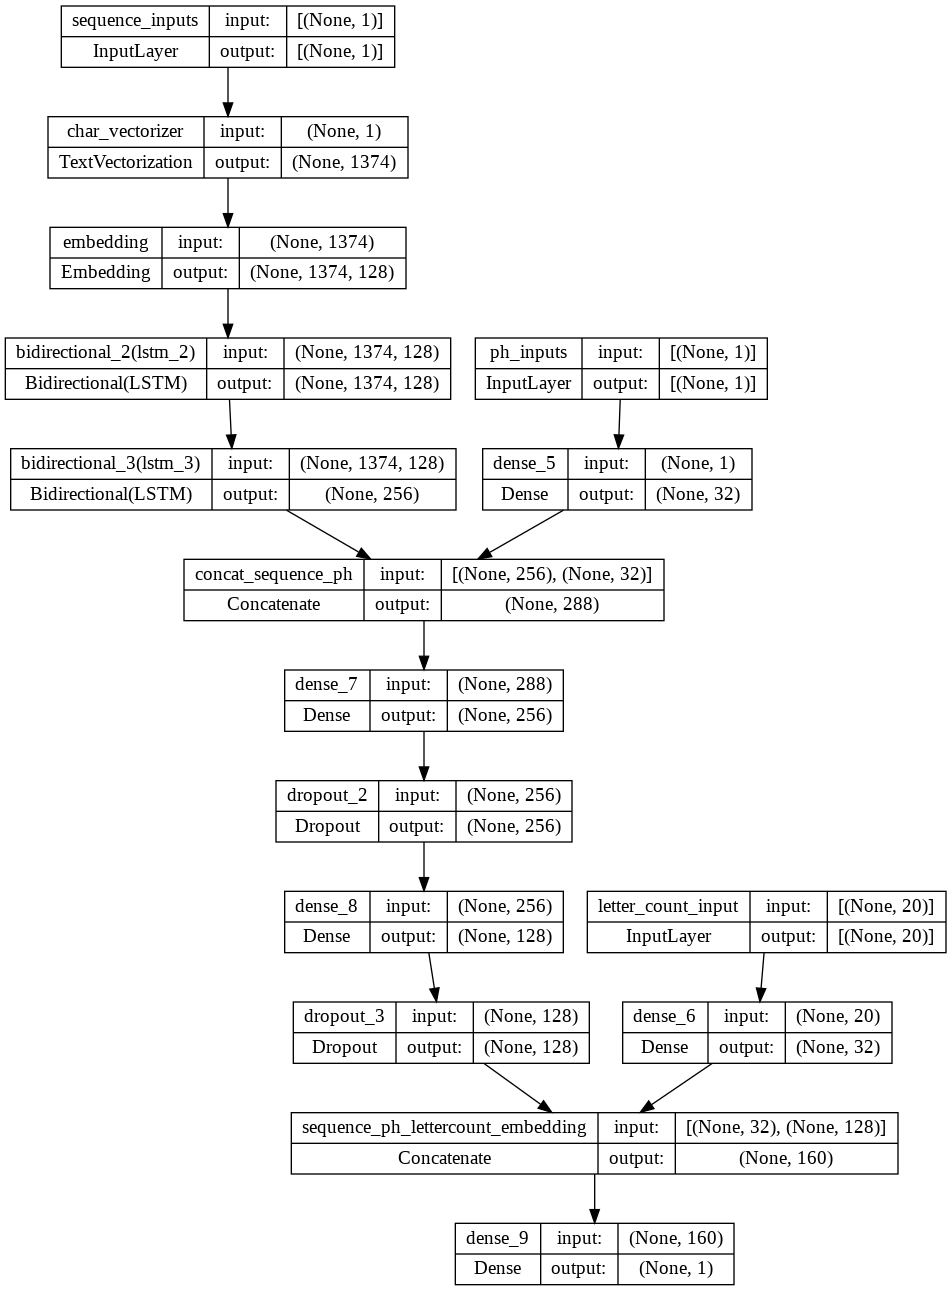

In [162]:
# PLot model_3 
from tensorflow.keras.utils import plot_model 
plot_model(model_3, show_shapes=True)

In [163]:
model_3.compile(loss='mse',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [164]:
history_3 = model_3.fit(tribrid_train_char_dataset, 
                        epochs=100,
                        steps_per_epoch = len(tribrid_train_char_dataset),
                        validation_data=tribrid_val_char_dataset,
                        validation_steps = len(tribrid_val_char_dataset),
                        callbacks=[reduce_lr, early_stopping, model_checkpoint(model_3.name)])

Epoch 1/100
852/852 [==============================] - 191s 204ms/step - loss: 188.1436 - mae: 9.8754 - mse: 188.1436 - val_loss: 97.2989 - val_mae: 7.1350 - val_mse: 97.2989 - lr: 0.0010
Epoch 2/100
852/852 [==============================] - 169s 199ms/step - loss: 120.0608 - mae: 8.2907 - mse: 120.0608 - val_loss: 86.3272 - val_mae: 6.9545 - val_mse: 86.3272 - lr: 0.0010
Epoch 3/100
852/852 [==============================] - 170s 199ms/step - loss: 110.8201 - mae: 7.9764 - mse: 110.8201 - val_loss: 87.4644 - val_mae: 7.2113 - val_mse: 87.4644 - lr: 0.0010
Epoch 4/100
852/852 [==============================] - 176s 206ms/step - loss: 105.4548 - mae: 7.7921 - mse: 105.4548 - val_loss: 79.6145 - val_mae: 6.7192 - val_mse: 79.6145 - lr: 0.0010
Epoch 5/100
852/852 [==============================] - 171s 201ms/step - loss: 117.1861 - mae: 8.1352 - mse: 117.1861 - val_loss: 111.4156 - val_mae: 7.9764 - val_mse: 111.4156 - lr: 0.0010
Epoch 6/100
852/852 [==============================] - 168

In [166]:
model_3.evaluate(tribrid_val_char_dataset)

45/45 [==============================] - 9s 101ms/step - loss: 58.8798 - mae: 5.6482 - mse: 58.8798


[58.879764556884766, 5.648226737976074, 58.879764556884766]

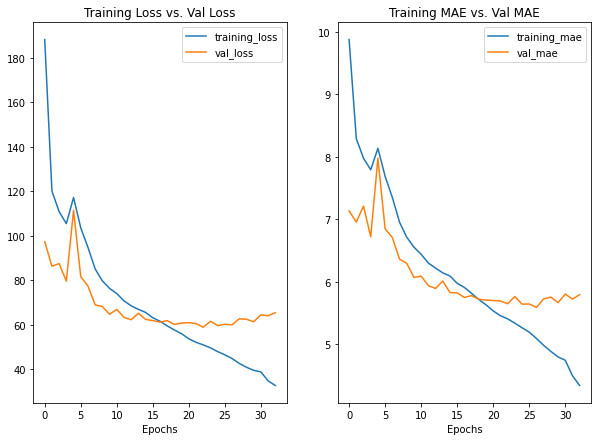

In [167]:
plot_historys(history_3)

In [ ]:
model_3_preds = model_3.predict(val_char_dataset)
model_3_preds[:50]

90/90 [==============================] - 15s 99ms/step


array([[35.981728],
       [48.23337 ],
       [54.10513 ],
       [37.45573 ],
       [37.925793],
       [37.4443  ],
       [43.249626],
       [37.642696],
       [38.91093 ],
       [36.8552  ],
       [41.2096  ],
       [37.07623 ],
       [39.22142 ],
       [44.23147 ],
       [37.274803],
       [39.197098],
       [38.482773],
       [54.387543],
       [54.755157],
       [34.523243],
       [39.10574 ],
       [39.57762 ],
       [49.460896],
       [40.610165],
       [38.997623],
       [37.647556],
       [38.10509 ],
       [38.570015],
       [39.504807],
       [45.78976 ],
       [35.126972],
       [48.450443],
       [48.08054 ],
       [39.966606],
       [46.986446],
       [46.31868 ],
       [38.064262],
       [45.436447],
       [43.641273],
       [56.35659 ],
       [40.719967],
       [42.225266],
       [61.856884],
       [38.1697  ],
       [51.423233],
       [35.899887],
       [39.097233],
       [37.942764],
       [41.46731 ],
       [42.37277 ]],

In [168]:
model_3.save("/content/drive/MyDrive/Novozyme_Competition/novozyme_competition/model_3_bidirectional_lstm_tribrid_letter_count_normalized")

In [ ]:
import tensorflow as tf
# Load model 
loaded_model_3 = tf.keras.models.load_model("/content/drive/MyDrive/Novozyme_Competition/novozyme_competition/model_3_bidirectional_lstm_2")

In [ ]:
loaded_model_3.evaluate(val_char_dataset)

90/90 [==============================] - 171s 2s/step - loss: 40.4014 - mae: 4.7388 - mse: 40.4014


[40.401432037353516, 4.738784313201904, 40.401432037353516]

In [177]:
model_3_preds = model_3.predict([test_letter_counts, test_char_seq, test_ph_norm])
model_3_preds

76/76 [==============================] - 3s 37ms/step


array([[49.066048],
       [48.95515 ],
       [49.03468 ],
       ...,
       [48.890373],
       [49.1917  ],
       [49.09229 ]], dtype=float32)

In [ ]:
model_3_preds[:50]

In [ ]:
list(tribrid_train_char_dataset.take(1).as_numpy_iterator())

In [186]:
# 1. Setup protein sequence inputs (tribrid model)
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_embeddings)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(32, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# 3. Set up letter count inputs 
letter_count_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="letter_count_input")
x = layers.Dense(32, activation='relu')(letter_count_inputs)
letter_count_model = tf.keras.Model(inputs=letter_count_inputs, 
                                    outputs=x)

# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])

z = layers.Dense(256, activation='relu')(sequence_ph_concat)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4
z = layers.Dense(128, activation='relu')(z)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4

# 5. Combine letter count embeddings with sequence and ph embeddings for tribrid model
z = layers.Concatenate(name='sequence_ph_lettercount_embedding')([letter_count_model.output, 
                                                                  z])
# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(z) 

# Construct the model 
model_4 = tf.keras.Model(inputs=[letter_count_model.input, sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_4_bidirectional_LSTM_tribrid_with_batch_norm')

In [187]:
model_4.compile(loss='mse',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [188]:
history_4 = model_4.fit(tribrid_train_char_dataset.take(50), 
                        epochs=10,
                        steps_per_epoch = len(tribrid_train_char_dataset.take(50)),
                        validation_data=tribrid_val_char_dataset,
                        validation_steps = len(tribrid_val_char_dataset),
                        callbacks=[reduce_lr, early_stopping, model_checkpoint(model_4.name)])

Epoch 1/10
50/50 [==============================] - 34s 381ms/step - loss: 2435.4363 - mae: 47.8503 - mse: 2435.4363 - val_loss: 2503.4316 - val_mae: 48.5957 - val_mse: 2503.4316 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 15s 291ms/step - loss: 821.2816 - mae: 24.1028 - mse: 821.2816 - val_loss: 1093.4215 - val_mae: 30.9716 - val_mse: 1093.4215 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 14s 287ms/step - loss: 300.6125 - mae: 13.6992 - mse: 300.6125 - val_loss: 678.3678 - val_mae: 23.6464 - val_mse: 678.3678 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 15s 306ms/step - loss: 235.0114 - mae: 12.0481 - mse: 235.0114 - val_loss: 427.8055 - val_mae: 17.8900 - val_mse: 427.8055 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 14s 288ms/step - loss: 194.9554 - mae: 10.7901 - mse: 194.9554 - val_loss: 264.2818 - val_mae: 13.3220 - val_mse: 264.2818 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - 14

In [189]:
# 1. Setup protein sequence inputs (tribrid model)
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_embeddings)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(32, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# 3. Set up letter count inputs 
letter_count_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="letter_count_input")
x = layers.Dense(32, activation='relu')(letter_count_inputs)
letter_count_model = tf.keras.Model(inputs=letter_count_inputs, 
                                    outputs=x)

# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])

z = layers.Dense(256, activation='relu')(sequence_ph_concat)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4
z = layers.Dense(128, activation='relu')(z)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4

# 5. Combine letter count embeddings with sequence and ph embeddings for tribrid model
z = layers.Concatenate(name='sequence_ph_lettercount_embedding')([letter_count_model.output, 
                                                                  z])

final_dense = layers.Dense(1024, activation='relu')(z)

# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(final_dense) 

# Construct the model 
model_5 = tf.keras.Model(inputs=[letter_count_model.input, sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_5_bidirectional_LSTM_tribrid_with_final_dense_plus_batch_norm')

In [ ]:
model_5.compile(loss='mae', 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [191]:
history_5 = model_5.fit(tribrid_train_char_dataset.take(50), 
                        epochs=10,
                        steps_per_epoch = len(tribrid_train_char_dataset.take(50)),
                        validation_data=tribrid_val_char_dataset,
                        validation_steps = len(tribrid_val_char_dataset))
                        #callbacks=[reduce_lr, early_stopping, model_checkpoint(model_4.name)])

Epoch 1/10
50/50 [==============================] - 34s 380ms/step - loss: 773.2157 - mae: 21.5014 - mse: 773.2157 - val_loss: 1546.3177 - val_mae: 37.5313 - val_mse: 1546.3177
Epoch 2/10
50/50 [==============================] - 15s 308ms/step - loss: 177.3243 - mae: 10.1504 - mse: 177.3243 - val_loss: 960.6403 - val_mae: 28.6948 - val_mse: 960.6403
Epoch 3/10
50/50 [==============================] - 14s 283ms/step - loss: 175.3003 - mae: 10.1397 - mse: 175.3003 - val_loss: 494.6175 - val_mae: 18.2423 - val_mse: 494.6175
Epoch 4/10
50/50 [==============================] - 14s 287ms/step - loss: 174.8918 - mae: 9.9264 - mse: 174.8918 - val_loss: 300.5040 - val_mae: 13.2445 - val_mse: 300.5040
Epoch 5/10
50/50 [==============================] - 14s 292ms/step - loss: 152.7605 - mae: 9.3987 - mse: 152.7605 - val_loss: 289.0637 - val_mae: 13.3736 - val_mse: 289.0637
Epoch 6/10
50/50 [==============================] - 14s 281ms/step - loss: 148.5576 - mae: 9.2715 - mse: 148.5576 - val_loss:

In [195]:
# 1. Setup protein sequence inputs (tribrid model)
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_embeddings)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(32, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# 3. Set up letter count inputs 
letter_count_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="letter_count_input")
x = layers.Dense(32, activation='relu')(letter_count_inputs)
letter_count_model = tf.keras.Model(inputs=letter_count_inputs, 
                                    outputs=x)

# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])

z = layers.Dense(1024, activation='relu')(sequence_ph_concat)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(256, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4
z = layers.Dense(128, activation='relu')(z)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4

# 5. Combine letter count embeddings with sequence and ph embeddings for tribrid model
z = layers.Concatenate(name='sequence_ph_lettercount_embedding')([letter_count_model.output, 
                                                                  z])

final_dense = layers.Dense(1024, activation='relu')(z)
x = layers.BatchNormalization()(final_dense)
x = layers.Dropout(0.2)(x)

# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(x) 

# Construct the model 
model_6 = tf.keras.Model(inputs=[letter_count_model.input, sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_6_bidirectional_LSTM_tribrid_with_final_dense_plus_batch_norm')

In [196]:
model_6.compile(loss='mse', 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [197]:
history_6 = model_6.fit(tribrid_train_char_dataset.take(50), 
                        epochs=10,
                        steps_per_epoch = len(tribrid_train_char_dataset.take(50)),
                        validation_data=tribrid_val_char_dataset,
                        validation_steps = len(tribrid_val_char_dataset))

Epoch 1/10
50/50 [==============================] - 36s 379ms/step - loss: 2661.5046 - mae: 50.3375 - mse: 2661.5046 - val_loss: 2586.1226 - val_mae: 49.5101 - val_mse: 2586.1226
Epoch 2/10
50/50 [==============================] - 14s 281ms/step - loss: 2280.6526 - mae: 46.4956 - mse: 2280.6526 - val_loss: 2180.9080 - val_mae: 45.1998 - val_mse: 2180.9080
Epoch 3/10
50/50 [==============================] - 15s 292ms/step - loss: 1527.4888 - mae: 37.3423 - mse: 1527.4888 - val_loss: 1243.8571 - val_mae: 33.1616 - val_mse: 1243.8571
Epoch 4/10
50/50 [==============================] - 14s 280ms/step - loss: 656.9750 - mae: 22.6059 - mse: 656.9750 - val_loss: 511.8063 - val_mae: 20.0307 - val_mse: 511.8063
Epoch 5/10
50/50 [==============================] - 14s 284ms/step - loss: 231.6481 - mae: 11.3917 - mse: 231.6481 - val_loss: 162.1407 - val_mae: 9.7419 - val_mse: 162.1407
Epoch 6/10
50/50 [==============================] - 14s 282ms/step - loss: 172.7452 - mae: 9.7237 - mse: 172.7452 

In [198]:
# 1. Setup protein sequence inputs (tribrid model)
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_embeddings)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(32, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# 3. Set up letter count inputs 
letter_count_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="letter_count_input")
x = layers.Dense(32, activation='relu')(letter_count_inputs)
letter_count_model = tf.keras.Model(inputs=letter_count_inputs, 
                                    outputs=x)

# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])

z = layers.Dense(1024, activation='relu')(sequence_ph_concat)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(256, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4
z = layers.Dense(128, activation='relu')(z)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4

# 5. Combine letter count embeddings with sequence and ph embeddings for tribrid model
z = layers.Concatenate(name='sequence_ph_lettercount_embedding')([letter_count_model.output, 
                                                                  z])

combined_dense = layers.Dense(1024, activation='relu')(z)
x = layers.BatchNormalization()(combined_dense)
x = layers.Dropout(0.2)(x)
final_dense = layers.Dense(128, activation='relu')(x)


# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(final_dense) 

# Construct the model 
model_7 = tf.keras.Model(inputs=[letter_count_model.input, sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_7_bidirectional_LSTM_tribrid_with_final_dense_plus_batch_norm')

In [199]:
model_7.compile(loss='mse', 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [200]:
history_7 = model_7.fit(tribrid_train_char_dataset.take(50), 
                        epochs=15,
                        steps_per_epoch = len(tribrid_train_char_dataset.take(50)),
                        validation_data=tribrid_val_char_dataset,
                        validation_steps = len(tribrid_val_char_dataset))

Epoch 1/15
50/50 [==============================] - 36s 401ms/step - loss: 1514.1227 - mae: 33.8302 - mse: 1514.1227 - val_loss: 1537.1100 - val_mae: 37.1030 - val_mse: 1537.1100
Epoch 2/15
50/50 [==============================] - 15s 295ms/step - loss: 153.9737 - mae: 9.3898 - mse: 153.9737 - val_loss: 892.3975 - val_mae: 27.3093 - val_mse: 892.3975
Epoch 3/15
50/50 [==============================] - 14s 283ms/step - loss: 137.1196 - mae: 8.7676 - mse: 137.1196 - val_loss: 473.4952 - val_mae: 18.1944 - val_mse: 473.4952
Epoch 4/15
50/50 [==============================] - 14s 282ms/step - loss: 119.8757 - mae: 8.2865 - mse: 119.8757 - val_loss: 339.4391 - val_mae: 14.4064 - val_mse: 339.4391
Epoch 5/15
50/50 [==============================] - 14s 283ms/step - loss: 125.4893 - mae: 8.4193 - mse: 125.4893 - val_loss: 202.0852 - val_mae: 9.8186 - val_mse: 202.0852
Epoch 6/15
50/50 [==============================] - 14s 282ms/step - loss: 120.5790 - mae: 8.3733 - mse: 120.5790 - val_loss: 

In [201]:
# 1. Setup protein sequence inputs (tribrid model)
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_embeddings)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(32, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# 3. Set up letter count inputs 
letter_count_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="letter_count_input")
x = layers.Dense(32, activation='relu')(letter_count_inputs)
letter_count_model = tf.keras.Model(inputs=letter_count_inputs, 
                                    outputs=x)

# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])

z = layers.Dense(1024, activation='relu')(sequence_ph_concat)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(256, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4
z = layers.Dense(128, activation='relu')(z)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(128, activation='relu')(z)


# 5. Combine letter count embeddings with sequence and ph embeddings for tribrid model
z = layers.Concatenate(name='sequence_ph_lettercount_embedding')([letter_count_model.output, 
                                                                  z])

combined_dense = layers.Dense(1024, activation='relu')(z)
x = layers.BatchNormalization()(combined_dense)
x = layers.Dropout(0.2)(x)
final_dense = layers.Dense(128, activation='relu')(x)


# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(final_dense) 

# Construct the model 
model_8 = tf.keras.Model(inputs=[letter_count_model.input, sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_8_bidirectional_LSTM_tribrid_with_final_dense_plus_batch_norm')

In [202]:
model_8.compile(loss='mse', 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [204]:
history_8 = model_8.fit(tribrid_train_char_dataset.take(50), 
                        epochs=10,
                        steps_per_epoch = len(tribrid_train_char_dataset.take(50)),
                        validation_data=tribrid_val_char_dataset,
                        validation_steps = len(tribrid_val_char_dataset))

Epoch 1/10
50/50 [==============================] - 34s 376ms/step - loss: 1247.7921 - mae: 29.6226 - mse: 1247.7921 - val_loss: 1108.9230 - val_mae: 31.1978 - val_mse: 1108.9230
Epoch 2/10
50/50 [==============================] - 14s 280ms/step - loss: 166.8642 - mae: 9.8433 - mse: 166.8642 - val_loss: 847.2447 - val_mae: 27.1097 - val_mse: 847.2447
Epoch 3/10
50/50 [==============================] - 16s 319ms/step - loss: 124.2527 - mae: 8.3607 - mse: 124.2527 - val_loss: 414.2649 - val_mae: 17.2507 - val_mse: 414.2649
Epoch 4/10
50/50 [==============================] - 14s 281ms/step - loss: 129.3833 - mae: 8.5478 - mse: 129.3833 - val_loss: 359.3076 - val_mae: 15.1141 - val_mse: 359.3076
Epoch 5/10
50/50 [==============================] - 14s 281ms/step - loss: 128.5794 - mae: 8.4342 - mse: 128.5794 - val_loss: 186.9581 - val_mae: 10.1695 - val_mse: 186.9581
Epoch 6/10
50/50 [==============================] - 14s 280ms/step - loss: 127.1391 - mae: 8.4841 - mse: 127.1391 - val_loss:

In [88]:
# 1. Setup protein sequence inputs (tribrid model)
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_embeddings)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(32, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# 3. Set up letter count inputs 
letter_count_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="letter_count_input")
x = layers.Dense(32, activation='relu')(letter_count_inputs)
letter_count_model = tf.keras.Model(inputs=letter_count_inputs, 
                                    outputs=x)

# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])

z = layers.Dense(1024, activation='relu')(sequence_ph_concat)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(256, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4
z = layers.Dense(128, activation='relu')(z)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.4)(z) # increase dropout to 0.4

# 5. Combine letter count embeddings with sequence and ph embeddings for tribrid model
z = layers.Concatenate(name='sequence_ph_lettercount_embedding')([letter_count_model.output, 
                                                                  z])

combined_dense = layers.Dense(1024, activation='relu')(z)
x = layers.BatchNormalization()(combined_dense)
x = layers.Dropout(0.2)(x)
final_dense = layers.Dense(128, activation='relu')(x)


# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(final_dense) 

# Construct the model 
model_9 = tf.keras.Model(inputs=[letter_count_model.input, sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_9_bidirectional_LSTM_tribrid_with_final_dense_plus_batch_norm')

In [89]:
model_9.compile(loss='mse', 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [91]:
model_9.load_weights("/content/drive/MyDrive/model_9_bidirectional_LSTM_tribrid_with_final_dense_plus_batch_norm")

In [92]:
model_9.evaluate(tribrid_val_char_dataset)

45/45 [==============================] - 22s 94ms/step - loss: 65.3219 - mae: 6.1246 - mse: 65.3219


[65.32186126708984, 6.124635696411133, 65.32186126708984]

In [93]:
history_9 = model_9.fit(tribrid_train_char_dataset, 
                        epochs=100,
                        steps_per_epoch = len(tribrid_train_char_dataset),
                        validation_data=tribrid_val_char_dataset,
                        validation_steps = len(tribrid_val_char_dataset),
                        callbacks=[early_stopping, reduce_lr, model_checkpoint(model_9.name)])

Epoch 1/100
852/852 [==============================] - 185s 200ms/step - loss: 67.1106 - mae: 6.1988 - mse: 67.1106 - val_loss: 99.1073 - val_mae: 8.1531 - val_mse: 99.1073 - lr: 0.0010
Epoch 2/100
852/852 [==============================] - 168s 197ms/step - loss: 65.1117 - mae: 6.1065 - mse: 65.1117 - val_loss: 68.1134 - val_mae: 6.3028 - val_mse: 68.1134 - lr: 0.0010
Epoch 3/100
852/852 [==============================] - 167s 196ms/step - loss: 66.2753 - mae: 6.1610 - mse: 66.2753 - val_loss: 73.6706 - val_mae: 6.6013 - val_mse: 73.6706 - lr: 0.0010
Epoch 4/100
852/852 [==============================] - 167s 195ms/step - loss: 63.1604 - mae: 6.0164 - mse: 63.1604 - val_loss: 62.8227 - val_mae: 5.8621 - val_mse: 62.8227 - lr: 0.0010
Epoch 5/100
852/852 [==============================] - 166s 195ms/step - loss: 61.3611 - mae: 5.9394 - mse: 61.3611 - val_loss: 66.9482 - val_mae: 6.2278 - val_mse: 66.9482 - lr: 0.0010
Epoch 6/100
852/852 [==============================] - 165s 194ms/step

In [94]:
model_9.save("/content/drive/MyDrive/Novozyme_Competition/novozyme_competition/model_9_tribrid__final_dense_batch_norm")

In [98]:
model_9_preds = model_9.predict([test_letter_counts, test_char_seq, test_ph_norm])
model_9_preds

76/76 [==============================] - 9s 25ms/step


array([[48.208103],
       [47.871414],
       [47.94139 ],
       ...,
       [47.92928 ],
       [47.97734 ],
       [48.211216]], dtype=float32)

In [99]:
model_9_preds[:50]

array([[48.208103],
       [47.871414],
       [47.94139 ],
       [48.013268],
       [47.981148],
       [48.04955 ],
       [48.05107 ],
       [48.129826],
       [48.010654],
       [47.85864 ],
       [48.002228],
       [48.193207],
       [47.961838],
       [47.938652],
       [47.929115],
       [48.24688 ],
       [47.902744],
       [48.08587 ],
       [47.916718],
       [48.054886],
       [48.10049 ],
       [48.14703 ],
       [47.979244],
       [48.156292],
       [47.94436 ],
       [48.301872],
       [48.283516],
       [48.328358],
       [48.217854],
       [48.30046 ],
       [48.25395 ],
       [48.251575],
       [48.223522],
       [48.312653],
       [48.078766],
       [48.347794],
       [48.30882 ],
       [48.283592],
       [48.001186],
       [47.924767],
       [47.95931 ],
       [48.187775],
       [48.094482],
       [48.215244],
       [48.331497],
       [48.236237],
       [48.370865],
       [48.338707],
       [48.284367],
       [48.187225]],

Let's make model_9 less complex and add some more regularization technqiues

In [108]:
from tensorflow.keras import regularizers

In [101]:
# 1. Setup protein sequence inputs (tribrid model)
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_embeddings)
sequence_outputs = layers.Bidirectional(layers.LSTM(64))(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(32, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# 3. Set up letter count inputs 
letter_count_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="letter_count_input")
x = layers.Dense(32, activation='relu')(letter_count_inputs)
letter_count_model = tf.keras.Model(inputs=letter_count_inputs, 
                                    outputs=x)

# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])

z = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(sequence_ph_concat)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dropout(0.5)(z) # increase dropout to 0.5
z = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(z)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dropout(0.5)(z) # increase dropout to 0.5
z = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(z)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dropout(0.5)(z) # increase dropout to 0.5

# 5. Combine letter count embeddings with sequence and ph embeddings for tribrid model
z = layers.Concatenate(name='sequence_ph_lettercount_embedding')([letter_count_model.output, 
                                                                  z])

combined_dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(z)
x = layers.BatchNormalization()(combined_dense)
x = layers.Dropout(0.4)(x)
final_dense = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)


# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(final_dense) 

# Construct the model 
model_10 = tf.keras.Model(inputs=[letter_count_model.input, sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_10_bidirectional_LSTM_tribrid_with_final_dense_plus_batch_norm_regul')

In [102]:
model_10.compile(loss='mse', 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

history_10 = model_10.fit(tribrid_train_char_dataset, 
                        epochs=100,
                        steps_per_epoch = len(tribrid_train_char_dataset),
                        validation_data=tribrid_val_char_dataset,
                        validation_steps = len(tribrid_val_char_dataset),
                        callbacks=[early_stopping, reduce_lr, model_checkpoint(model_10.name)])

Epoch 1/100
852/852 [==============================] - 183s 198ms/step - loss: 330.7422 - mae: 12.5635 - mse: 329.5501 - val_loss: 186.0527 - val_mae: 9.5606 - val_mse: 184.8051 - lr: 0.0010
Epoch 2/100
852/852 [==============================] - 164s 192ms/step - loss: 128.6558 - mae: 8.4711 - mse: 127.3668 - val_loss: 133.9295 - val_mae: 7.8978 - val_mse: 132.6115 - lr: 0.0010
Epoch 3/100
852/852 [==============================] - 164s 192ms/step - loss: 119.4257 - mae: 8.1863 - mse: 118.0812 - val_loss: 134.1194 - val_mae: 7.9100 - val_mse: 132.7463 - lr: 0.0010
Epoch 4/100
852/852 [==============================] - 163s 191ms/step - loss: 112.3441 - mae: 7.9220 - mse: 110.9472 - val_loss: 133.0025 - val_mae: 8.0206 - val_mse: 131.5818 - lr: 0.0010
Epoch 5/100
852/852 [==============================] - 163s 191ms/step - loss: 107.5263 - mae: 7.7358 - mse: 106.0721 - val_loss: 123.7592 - val_mae: 8.1657 - val_mse: 122.2675 - lr: 0.0010
Epoch 6/100
852/852 [============================

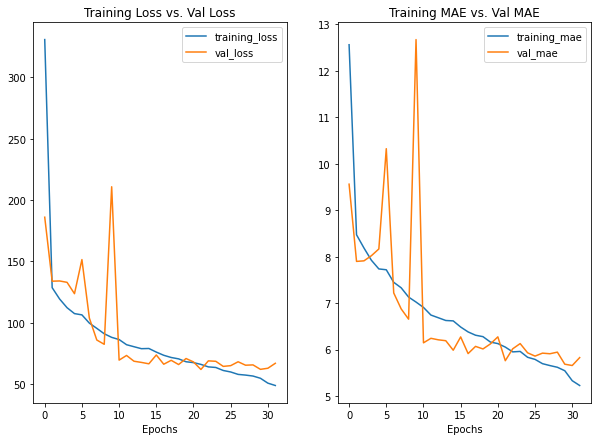

In [109]:
plot_historys(history_10)

In [103]:
model_10.evaluate(tribrid_val_char_dataset)

45/45 [==============================] - 8s 178ms/step - loss: 62.0335 - mae: 5.7594 - mse: 59.6189


[62.033546447753906, 5.759425163269043, 59.618934631347656]

In [ ]:
model_10_preds = model_10.predict([test_letter_counts, test_char_seq, test_ph_norm])
model_10_preds[:100]

In [107]:
model_10.save("/content/drive/MyDrive/Novozyme_Competition/novozyme_competition/model_10_tribrid__final_dense_batch_norm")

In [116]:
# 1. Setup protein sequence inputs (tribrid model)
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(sequence_embeddings)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(64, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# 3. Set up letter count inputs 
letter_count_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="letter_count_input")
letter_count_outputs = layers.Dense(64, activation='relu')(letter_count_inputs)
letter_count_model = tf.keras.Model(inputs=letter_count_inputs, 
                                    outputs=letter_count_outputs)

# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])

z = layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001))(sequence_ph_concat)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dropout(0.5)(z) # increase dropout to 0.5
z = layers.Dense(256, activation='elu', kernel_regularizer=regularizers.l2(0.001))(z)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dropout(0.5)(z) # increase dropout to 0.5

# 5. Combine letter count embeddings with sequence and ph embeddings for tribrid model
z = layers.Concatenate(name='sequence_ph_lettercount_embedding')([letter_count_model.output, 
                                                                  z])

combined_dense = layers.Dense(256, activation='elu', kernel_regularizer=regularizers.l2(0.001))(z)
x = layers.BatchNormalization()(combined_dense)
x = layers.Dropout(0.3)(x)

# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(x) 

# Construct the model 
model_11 = tf.keras.Model(inputs=[letter_count_model.input, sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_11_bidirectional_LSTM_tribrid_with_final_dense_plus_batch_norm_regul')

In [117]:
model_11.compile(loss='mse', 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae', 'mse'])

history_11 = model_11.fit(tribrid_train_char_dataset, 
                        epochs=100,
                        steps_per_epoch = len(tribrid_train_char_dataset),
                        validation_data=tribrid_val_char_dataset,
                        validation_steps = len(tribrid_val_char_dataset),
                        callbacks=[early_stopping, reduce_lr, model_checkpoint(model_11.name)])

Epoch 1/100
852/852 [==============================] - 105s 113ms/step - loss: 817.3483 - mae: 21.5163 - mse: 816.1539 - val_loss: 111.1778 - val_mae: 7.8388 - val_mse: 109.7310 - lr: 0.0010
Epoch 2/100
852/852 [==============================] - 94s 111ms/step - loss: 127.4971 - mae: 8.5227 - mse: 125.6846 - val_loss: 104.0226 - val_mae: 7.3570 - val_mse: 101.8528 - lr: 0.0010
Epoch 3/100
852/852 [==============================] - 95s 112ms/step - loss: 119.0612 - mae: 8.2373 - mse: 116.4679 - val_loss: 94.7613 - val_mae: 7.3991 - val_mse: 91.8887 - lr: 0.0010
Epoch 4/100
852/852 [==============================] - 99s 116ms/step - loss: 106.9952 - mae: 7.7194 - mse: 103.9433 - val_loss: 83.8910 - val_mae: 6.7954 - val_mse: 80.6918 - lr: 0.0010
Epoch 5/100
852/852 [==============================] - 97s 113ms/step - loss: 98.4825 - mae: 7.3621 - mse: 95.2363 - val_loss: 76.9357 - val_mae: 6.3626 - val_mse: 73.7121 - lr: 0.0010
Epoch 6/100
852/852 [==============================] - 96s 11

In [122]:
model_11.save("/content/drive/MyDrive/Novozyme_Competition/novozyme_competition/model_11_tribrid__final_dense_batch_norm")

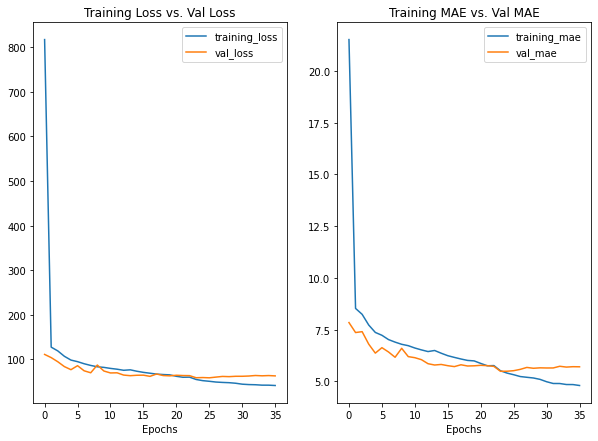

In [119]:
plot_historys(history_11)

In [120]:
model_11.evaluate(tribrid_val_char_dataset)

45/45 [==============================] - 2s 50ms/step - loss: 58.8522 - mae: 5.4841 - mse: 55.2607


[58.85218811035156, 5.4840617179870605, 55.26070785522461]

In [123]:
model_11_preds = model_11.predict([test_letter_counts, test_char_seq, test_ph_norm])
model_11_preds[:50]

76/76 [==============================] - 3s 32ms/step


array([[46.558266],
       [46.49897 ],
       [46.52664 ],
       [46.59447 ],
       [46.81723 ],
       [46.65324 ],
       [46.627914],
       [46.562607],
       [46.629414],
       [46.566307],
       [46.710934],
       [46.713497],
       [46.66867 ],
       [46.720634],
       [46.61566 ],
       [46.730366],
       [46.634506],
       [46.6311  ],
       [46.61422 ],
       [46.689583],
       [46.781246],
       [46.73878 ],
       [46.768845],
       [46.64822 ],
       [46.78521 ],
       [46.689865],
       [46.644844],
       [46.68017 ],
       [46.584938],
       [46.65805 ],
       [46.661953],
       [46.591015],
       [46.61848 ],
       [46.706512],
       [46.663033],
       [46.728813],
       [46.75877 ],
       [46.733074],
       [46.62698 ],
       [46.59574 ],
       [46.634037],
       [46.635242],
       [46.57834 ],
       [46.60846 ],
       [46.62915 ],
       [46.613926],
       [46.650402],
       [46.63614 ],
       [46.633144],
       [46.569687]],

In [127]:
# 1. Setup protein sequence inputs (tribrid model)
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(sequence_embeddings)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(64, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# 3. Set up letter count inputs 
letter_count_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="letter_count_input")
letter_count_outputs = layers.Dense(64, activation='relu')(letter_count_inputs)
letter_count_model = tf.keras.Model(inputs=letter_count_inputs, 
                                    outputs=letter_count_outputs)

# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])

z = layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.002))(sequence_ph_concat)
z = layers.BatchNormalization()(z) # Add in BatchNorm layer
z = layers.Dropout(0.5)(z) # increase dropout to 0.5


# 5. Combine letter count embeddings with sequence and ph embeddings for tribrid model
z = layers.Concatenate(name='sequence_ph_lettercount_embedding')([letter_count_model.output, 
                                                                  z])

combined_dense = layers.Dense(256, activation='elu', kernel_regularizer=regularizers.l2(0.002))(z)
x = layers.Dropout(0.3)(combined_dense)
final_dense = layers.Dense(128, activation='elu')(x)
final_dropout = layers.Dropout(0.3)(final_dense)

# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(final_dropout) 

# Construct the model 
model_12 = tf.keras.Model(inputs=[letter_count_model.input, sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_12_bidirectional_LSTM_tribrid_with_final_dense_plus_batch_norm_regul')

In [128]:
model_12.summary()

Model: "model_12_bidirectional_LSTM_tribrid_with_final_dense_plus_batch_norm_regul"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_inputs (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 2114)        0           ['sequence_inputs[0][0]']        
 tion)                                                                                            
                                                                                                  
 embedding_1 (Embedding)        (None, 2114, 512)    10240       ['char_vectorizer[5][0]']        
                                                                                                  
 ph_inputs (InputLayer)  

In [129]:
model_12.compile(loss='mse', 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae', 'mse'])

history_12 = model_12.fit(tribrid_train_char_dataset, 
                        epochs=100,
                        steps_per_epoch = len(tribrid_train_char_dataset),
                        validation_data=tribrid_val_char_dataset,
                        validation_steps = len(tribrid_val_char_dataset),
                        callbacks=[early_stopping, reduce_lr, model_checkpoint(model_12.name)])

Epoch 1/100
852/852 [==============================] - 145s 161ms/step - loss: 240.1212 - mae: 11.0297 - mse: 238.2833 - val_loss: 435.2480 - val_mae: 19.1698 - val_mse: 433.2514 - lr: 0.0010
Epoch 2/100
852/852 [==============================] - 138s 163ms/step - loss: 114.9333 - mae: 8.0352 - mse: 112.9233 - val_loss: 479.7473 - val_mae: 20.1952 - val_mse: 477.7216 - lr: 0.0010
Epoch 3/100
852/852 [==============================] - 134s 157ms/step - loss: 104.8041 - mae: 7.6711 - mse: 102.7343 - val_loss: 88.9221 - val_mae: 6.9195 - val_mse: 86.8177 - lr: 0.0010
Epoch 4/100
852/852 [==============================] - 133s 156ms/step - loss: 95.0786 - mae: 7.2861 - mse: 92.9622 - val_loss: 100.7259 - val_mae: 7.3828 - val_mse: 98.5984 - lr: 0.0010
Epoch 5/100
852/852 [==============================] - 132s 155ms/step - loss: 92.2491 - mae: 7.1501 - mse: 90.1114 - val_loss: 199.6405 - val_mae: 11.5036 - val_mse: 197.4736 - lr: 0.0010
Epoch 6/100
852/852 [==============================] 

In [130]:
model_12.save("/content/drive/MyDrive/Novozyme_Competition/novozyme_competition/model_12_tribrid__final_dense_batch_norm")

In [132]:
model_12.evaluate(tribrid_val_char_dataset)

45/45 [==============================] - 8s 174ms/step - loss: 62.7639 - mae: 5.7112 - mse: 59.6807


[62.763938903808594, 5.7111735343933105, 59.68071746826172]

In [134]:
model_12_preds = model_12.predict(tribrid_val_char_dataset)
model_12_preds[:50]

45/45 [==============================] - 5s 109ms/step


array([[48.17907 ],
       [47.626133],
       [45.992638],
       [46.108936],
       [63.348827],
       [49.42348 ],
       [51.548046],
       [64.53137 ],
       [82.05693 ],
       [48.735104],
       [44.72913 ],
       [71.9305  ],
       [72.10826 ],
       [85.164894],
       [50.300377],
       [53.90262 ],
       [51.234253],
       [51.2845  ],
       [44.40363 ],
       [58.245285],
       [46.877293],
       [48.465107],
       [49.394997],
       [51.94977 ],
       [85.59001 ],
       [46.74009 ],
       [50.669598],
       [49.356377],
       [47.576077],
       [48.672913],
       [64.08677 ],
       [47.111248],
       [64.11992 ],
       [47.481293],
       [48.57726 ],
       [49.485252],
       [48.10896 ],
       [48.668236],
       [47.690834],
       [47.31583 ],
       [49.63921 ],
       [46.83821 ],
       [50.50518 ],
       [48.69662 ],
       [67.27834 ],
       [59.531044],
       [47.369495],
       [49.290096],
       [46.521667],
       [47.64896 ]],

In [110]:
# 1. Setup protein sequence inputs
sequence_inputs = layers.Input(shape=(1,), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_embeddings)
sequence_outputs = layers.Bidirectional(layers.LSTM(128))(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='ph_inputs')
pH_outputs = layers.Dense(128, activation='relu')(pH_inputs)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)


# 4. Concatenate sequence and pH inputs 
sequence_ph_concat = layers.Concatenate(name='concat_sequence_ph')([sequence_model.output, 
                                                                    pH_model.output])


# 6. Create output layers
combined_dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(sequence_ph_concat)
combined_dropout = layers.Dropout(0.5)(combined_dense)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(combined_dropout)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
final_dropout = layers.Dropout(0.3)(x)

# 7. Create output layer
output_layer = layers.Dense(1, activation='linear')(final_dropout) 

# Construct the model 
model_13 = tf.keras.Model(inputs=[sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_13_bidirectional_LSTM_with_l2_norm_dropout')

In [120]:
model_13.summary()

Model: "model_13_bidirectional_LSTM_with_l2_norm_dropout"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_inputs (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 2114)        0           ['sequence_inputs[0][0]']        
 tion)                                                                                            
                                                                                                  
 embedding_1 (Embedding)        (None, 2114, 256)    5632        ['char_vectorizer[2][0]']        
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 2114, 128) 

In [112]:
model_13.compile(loss='mse', 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae', 'mse'])

history_13 = model_13.fit(train_char_dataset, 
                        epochs=100,
                        steps_per_epoch = len(train_char_dataset),
                        validation_data=val_char_dataset,
                        validation_steps = len(val_char_dataset),
                        callbacks=[early_stopping, reduce_lr, model_checkpoint(model_13.name)])

Epoch 1/100
852/852 [==============================] - 241s 261ms/step - loss: 260.7949 - mae: 11.9888 - mse: 260.4953 - val_loss: 113.6975 - val_mae: 7.5839 - val_mse: 113.4283 - lr: 0.0010
Epoch 2/100
852/852 [==============================] - 234s 275ms/step - loss: 176.8528 - mae: 10.1609 - mse: 176.5892 - val_loss: 96.1705 - val_mae: 7.3799 - val_mse: 95.9133 - lr: 0.0010
Epoch 3/100
852/852 [==============================] - 236s 278ms/step - loss: 157.6811 - mae: 9.6238 - mse: 157.4321 - val_loss: 93.4260 - val_mae: 7.2055 - val_mse: 93.1855 - lr: 0.0010
Epoch 4/100
852/852 [==============================] - 232s 273ms/step - loss: 144.4534 - mae: 9.1555 - mse: 144.2211 - val_loss: 108.0276 - val_mae: 7.9844 - val_mse: 107.8011 - lr: 0.0010
Epoch 5/100
852/852 [==============================] - 232s 273ms/step - loss: 129.0905 - mae: 8.6299 - mse: 128.8656 - val_loss: 91.7556 - val_mae: 6.9885 - val_mse: 91.5267 - lr: 0.0010
Epoch 6/100
852/852 [==============================] -

In [113]:
model_13.save("/content/drive/MyDrive/Novozyme_Competition/novozyme_competition/model_13_biLSTM_two_input_with_regularization")

In [114]:
model_13.evaluate(val_char_dataset)

45/45 [==============================] - 7s 145ms/step - loss: 59.1115 - mae: 5.6920 - mse: 58.9087


[59.11146545410156, 5.6920318603515625, 58.908660888671875]

In [115]:
model_13_preds = model_13.predict(val_char_dataset)
model_13_preds[:20]

45/45 [==============================] - 11s 137ms/step


array([[46.057384],
       [46.578583],
       [46.140156],
       [46.1386  ],
       [64.20221 ],
       [46.073307],
       [46.033875],
       [61.597042],
       [88.51113 ],
       [46.035778],
       [46.10072 ],
       [82.51499 ],
       [66.753456],
       [83.481834],
       [47.789406],
       [58.367916],
       [50.78157 ],
       [49.252792],
       [46.03713 ],
       [53.8818  ]], dtype=float32)

In [119]:
model_13_test_preds = model_13.predict([test_char_seq, test_ph_norm])
model_13_test_preds[:30]

76/76 [==============================] - 9s 29ms/step


array([[46.221405],
       [46.31897 ],
       [46.263584],
       [46.220848],
       [46.216854],
       [46.233154],
       [46.21497 ],
       [46.19687 ],
       [46.241184],
       [46.25862 ],
       [46.236187],
       [46.20945 ],
       [46.214005],
       [46.20268 ],
       [46.239426],
       [46.210735],
       [46.2398  ],
       [46.22797 ],
       [46.24913 ],
       [46.218143],
       [46.198566],
       [46.224228],
       [46.3342  ],
       [46.228287],
       [46.31084 ],
       [46.219032],
       [46.250843],
       [46.184895],
       [46.245438],
       [46.196148]], dtype=float32)

## GRU Model

In [ ]:
# 1. Setup protein sequence inputs
sequence_inputs = layers.Input(shape=(1), dtype=tf.string, name='sequence_inputs')
sequence_vectors = char_vectorizer(sequence_inputs)
sequence_embeddings = character_embedding(sequence_vectors)
x = layers.GRU(64, return_sequences=True)(sequence_embeddings)
sequence_outputs = layers.GRU(64)(x)
sequence_model = tf.keras.Model(inputs = sequence_inputs, outputs = sequence_outputs)

# 2. Setup pH inputs/Model
pH_inputs = layers.Input(shape=(1,), dtype=tf.float32, name='pH_inputs')
norm1 = normalizer1(pH_inputs)
pH_outputs = layers.Dense(128, activation='relu')(norm1)
pH_model = tf.keras.Model(inputs = pH_inputs, outputs = pH_outputs)

# Concatenate sequence and pH inputs 
sequence_pH_concat = layers.Concatenate(name='concatenation')([sequence_model.output, 
                                                               pH_model.output])

combined_dense = layers.Dense(128, activation='relu')(sequence_pH_concat)
output_layer = layers.Dense(1, activation='linear')(combined_dense) 

# Construct the model 
model_14 = tf.keras.Model(inputs=[sequence_model.input, pH_model.input],
                         outputs=output_layer,
                         name='model_14_GRU')

In [ ]:
model_14.compile(loss='mse',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [ ]:
history_14 = model_4.fit(train_char_dataset, 
                        epochs=5,
                        steps_per_epoch = len(train_char_dataset),
                        validation_data=val_char_dataset,
                        validation_steps = int(0.25*len(val_char_dataset)),
                        callbacks=[reduce_lr, early_stopping, model_checkpoint(model_14.name)]))

Epoch 1/5
90/90 [==============================] - 8s 12ms/step - loss: nan - mae: nan - mse: nan
Epoch 2/5
90/90 [==============================] - 1s 12ms/step - loss: nan - mae: nan - mse: nan
Epoch 3/5
90/90 [==============================] - 1s 12ms/step - loss: nan - mae: nan - mse: nan
Epoch 4/5
90/90 [==============================] - 1s 12ms/step - loss: nan - mae: nan - mse: nan
Epoch 5/5
90/90 [==============================] - 1s 12ms/step - loss: nan - mae: nan - mse: nan


In [ ]:
# Function to calculate spearman correlation coefficient
def spearman_coef(model, true_targets, test_dataset):
  """
  Function to calcualte the spearman_coef of a trained model's results

  Args
  --------
  model :  a trained Tensorflow model 

  true_targets : 

  Returns
  --------
  the spearmanr coefficient for the model's predictions and the true_targets

  """
  # Make predictions on test sequences and pH
  pred_targets = model.predict(test_dataset)

  return spearmanr(pred_targets, true_targets)

In [ ]:
test_df.head()

In [ ]:
import wandb

wandb.init(project='novoenyme_competition')
# # 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 0.01
# Model training here 
# 3. Log metrics over time to visualize performance
# with tf.Session() as sess:
# # ...
# #wandb.tensorflow.log(tf.summary.merge_all())